In [5]:
import pandas as pd
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
import geopandas as gpd
import pickle

from geopandas import GeoDataFrame
from shapely.geometry import Point
from matplotlib.ticker import FormatStrFormatter
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, auc, confusion_matrix 
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

In [2]:
# Содержимое файла 'ga_sessions.csv'.
df_sessions = pd.read_csv('data/ga_sessions.csv', low_memory=False)
df_sessions.head()

,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,device_category,device_os,device_brand,device_model,device_screen_resolution,device_browser,geo_country,geo_city
0,9055434745589932991.1637753792.1637753792,2108382700.1637753791,2021-11-24,14:36:32,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,NaN,360x720,Chrome,Russia,Zlatoust
1,905544597018549464.1636867290.1636867290,210838531.1636867288,2021-11-14,08:21:30,1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,IGUCNvHlhfHpROGclCit,mobile,Android,Samsung,NaN,385x854,Samsung Internet,Russia,Moscow
2,9055446045651783499.1640648526.1640648526,2108385331.1640648523,2021-12-28,02:42:06,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,NaN,360x720,Chrome,Russia,Krasnoyarsk
3,9055447046360770272.1622255328.1622255328,2108385564.1622255328,2021-05-29,05:00:00,1,kjsLglQLzykiRbcDiGcD,cpc,NaN,NOBKLgtuvqYWkXQHeYWM,NaN,mobile,NaN,Xiaomi,NaN,393x786,Chrome,Russia,Moscow
4,9055447046360770272.1622255345.1622255345,2108385564.1622255328,2021-05-29,05:00:00,2,kjsLglQLzykiRbcDiGcD,cpc,NaN,NaN,NaN,mobile,NaN,Xiaomi,NaN,393x786,Chrome,Russia,Moscow


In [3]:
df_sessions.shape

(1860042, 18)

In [4]:
# Убедимся,что все значения колонки 'session_id' датафрейма df_sessions уникальны.
df_sessions.session_id.nunique()

1860042

In [5]:
# Содержимое файла 'ga_hits.csv'.
df_hits = pd.read_csv('data/ga_hits.csv', low_memory=False)
df_hits.head()

,session_id,hit_date,hit_time,hit_number,hit_type,hit_referer,hit_page_path,event_category,event_action,event_label,event_value
0,5639623078712724064.1640254056.1640254056,2021-12-23,597864.0,30,event,NaN,sberauto.com/cars?utm_source_initial=google&ut...,quiz,quiz_show,NaN,NaN
1,7750352294969115059.1640271109.1640271109,2021-12-23,597331.0,41,event,NaN,sberauto.com/cars/fiat?city=1&city=18&rental_c...,quiz,quiz_show,NaN,NaN
2,885342191847998240.1640235807.1640235807,2021-12-23,796252.0,49,event,NaN,sberauto.com/cars/all/volkswagen/polo/e994838f...,quiz,quiz_show,NaN,NaN
3,142526202120934167.1640211014.1640211014,2021-12-23,934292.0,46,event,NaN,sberauto.com/cars?utm_source_initial=yandex&ut...,quiz,quiz_show,NaN,NaN
4,3450086108837475701.1640265078.1640265078,2021-12-23,768741.0,79,event,NaN,sberauto.com/cars/all/mercedes-benz/cla-klasse...,quiz,quiz_show,NaN,NaN


In [6]:
df_hits.shape

(15726470, 11)

In [7]:
# Убедимся,что не все значения колонки 'session_id' датафрейма df_hits уникальны.
df_hits.session_id.nunique()

1734610

# Dataframe merge

In [8]:
# Добавим к датафрейму df_hits целевую колонку 'target'.
# Положим в неё значение '1', если действие из колонки 'event_action' является целевым (из перечня действий, согласно условию).
# Если действие из колонки 'event_action' не является целевым, в колонку 'target' положим '0'.
actions = ['sub_car_claim_click', 'sub_car_claim_submit_click', 'sub_open_dialog_click', 'sub_custom_question_submit_click',
'sub_call_number_click', 'sub_callback_submit_click', 'sub_submit_success', 'sub_car_request_submit_click']
df_hits['target'] = df_hits.apply(lambda x: 1 if x.event_action in actions else 0, axis=1)
df_hits.head()

,session_id,hit_date,hit_time,hit_number,hit_type,hit_referer,hit_page_path,event_category,event_action,event_label,event_value,target
0,5639623078712724064.1640254056.1640254056,2021-12-23,597864.0,30,event,NaN,sberauto.com/cars?utm_source_initial=google&ut...,quiz,quiz_show,NaN,NaN,0
1,7750352294969115059.1640271109.1640271109,2021-12-23,597331.0,41,event,NaN,sberauto.com/cars/fiat?city=1&city=18&rental_c...,quiz,quiz_show,NaN,NaN,0
2,885342191847998240.1640235807.1640235807,2021-12-23,796252.0,49,event,NaN,sberauto.com/cars/all/volkswagen/polo/e994838f...,quiz,quiz_show,NaN,NaN,0
3,142526202120934167.1640211014.1640211014,2021-12-23,934292.0,46,event,NaN,sberauto.com/cars?utm_source_initial=yandex&ut...,quiz,quiz_show,NaN,NaN,0
4,3450086108837475701.1640265078.1640265078,2021-12-23,768741.0,79,event,NaN,sberauto.com/cars/all/mercedes-benz/cla-klasse...,quiz,quiz_show,NaN,NaN,0


In [9]:
# Подсчет количества значений целевой переменной.
df_hits.target.value_counts()

0    15621562
1      104908
Name: target, dtype: int64

In [10]:
# Создание датафрейма из двух колонок, которые будут присоединены к датафрейму df_sessions.
df_hits_upd = df_hits[['session_id','target']]
df_hits_upd.head()

,session_id,target
0,5639623078712724064.1640254056.1640254056,0
1,7750352294969115059.1640271109.1640271109,0
2,885342191847998240.1640235807.1640235807,0
3,142526202120934167.1640211014.1640211014,0
4,3450086108837475701.1640265078.1640265078,0


In [11]:
# Так как в рамках одного 'session_id' могло быть несколько действий, как целевых, так и нецелевых, удалим строки-дубликаты.
df_hits_upd_2 = df_hits_upd.drop_duplicates()
df_hits_upd_2.shape

(1784748, 2)

In [12]:
# Вывод количества уникальных значений колонки 'session_id'.
df_hits_upd_2.session_id.nunique()
# Это даёт нам понять, что одному значению 'session_id' может одновременно соответствовать как '1', так и '0' из целевой колонки.

1734610

In [13]:
# Используем хитрый приём: сделаем группировку датафрейма с агрегирующей функцией 'sum'.
# Это позволит избавиться от дублей в 'session_id', которым соответствуют 'target'=0.
# Все значения 'session_id' станут уникальными, и им будут соответствовать либо '1', либо '0' из целнвой колонки.
df_hits_upd_3 = df_hits_upd_2.groupby(['session_id'], as_index=False).sum()
df_hits_upd_3.shape

(1734610, 2)

In [14]:
# Снова подсчет количества значений целевой переменной.
df_hits_upd_3.target.value_counts()

0    1683850
1      50760
Name: target, dtype: int64

In [15]:
# Объединим датафреймы df_sessions и df_hits_upd_3 по значениям колоки 'session_id', которые есть в обеих таблицах.
df = pd.merge(left=df_sessions, right=df_hits_upd_3, on='session_id', how='inner')
df.shape

(1732266, 19)

In [16]:
# Финальный подсчет количества значений целевой переменной.
df.target.value_counts()

0    1681952
1      50314
Name: target, dtype: int64

# Data preparation

In [17]:
# Посмотрим на названия колонок (и содержимое колонок) и подумаем над планом действий.
df.head()

,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,device_category,device_os,device_brand,device_model,device_screen_resolution,device_browser,geo_country,geo_city,target
0,9055434745589932991.1637753792.1637753792,2108382700.1637753791,2021-11-24,14:36:32,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,NaN,360x720,Chrome,Russia,Zlatoust,0
1,905544597018549464.1636867290.1636867290,210838531.1636867288,2021-11-14,08:21:30,1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,IGUCNvHlhfHpROGclCit,mobile,Android,Samsung,NaN,385x854,Samsung Internet,Russia,Moscow,0
2,9055446045651783499.1640648526.1640648526,2108385331.1640648523,2021-12-28,02:42:06,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,NaN,360x720,Chrome,Russia,Krasnoyarsk,0
3,9055447046360770272.1622255328.1622255328,2108385564.1622255328,2021-05-29,05:00:00,1,kjsLglQLzykiRbcDiGcD,cpc,NaN,NOBKLgtuvqYWkXQHeYWM,NaN,mobile,NaN,Xiaomi,NaN,393x786,Chrome,Russia,Moscow,0
4,9055447046360770272.1622255345.1622255345,2108385564.1622255328,2021-05-29,05:00:00,2,kjsLglQLzykiRbcDiGcD,cpc,NaN,NaN,NaN,mobile,NaN,Xiaomi,NaN,393x786,Chrome,Russia,Moscow,0


In [18]:
# Сразу же удалим те колонки 'session_id' и 'client_id'.
# Так как использование порядковых номеров ("айдишников") при обучении модели является неправильной практикой.
df = df.drop(columns=['session_id','client_id'])    

In [19]:
# Вывод информации одатасете.
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1732266 entries, 0 to 1732265
Data columns (total 17 columns):
 #   Column                    Dtype 
---  ------                    ----- 
 0   visit_date                object
 1   visit_time                object
 2   visit_number              int64 
 3   utm_source                object
 4   utm_medium                object
 5   utm_campaign              object
 6   utm_adcontent             object
 7   utm_keyword               object
 8   device_category           object
 9   device_os                 object
 10  device_brand              object
 11  device_model              object
 12  device_screen_resolution  object
 13  device_browser            object
 14  geo_country               object
 15  geo_city                  object
 16  target                    int64 
dtypes: int64(2), object(15)
memory usage: 237.9+ MB


### Пропущенные и неинформационные значения

In [20]:
# Вывод количества пропущенных значений для каждого признака в порядке убывания.
df.isna().sum().sort_values(ascending=False)

device_model                1717204
utm_keyword                 1020752
device_os                   1013964
device_brand                 347196
utm_adcontent                304137
utm_campaign                 195287
utm_source                       76
target                            0
visit_time                        0
visit_number                      0
utm_medium                        0
device_category                   0
geo_city                          0
device_screen_resolution          0
device_browser                    0
geo_country                       0
visit_date                        0
dtype: int64

In [21]:
missing_values = round((df.isna().sum() / len(df)) * 100, 2).sort_values(ascending=False)

print('Процент пропущенных значений:')
missing_values

Процент пропущенных значений:


device_model                99.13
utm_keyword                 58.93
device_os                   58.53
device_brand                20.04
utm_adcontent               17.56
utm_campaign                11.27
target                       0.00
visit_time                   0.00
visit_number                 0.00
utm_source                   0.00
utm_medium                   0.00
device_category              0.00
geo_city                     0.00
device_screen_resolution     0.00
device_browser               0.00
geo_country                  0.00
visit_date                   0.00
dtype: float64

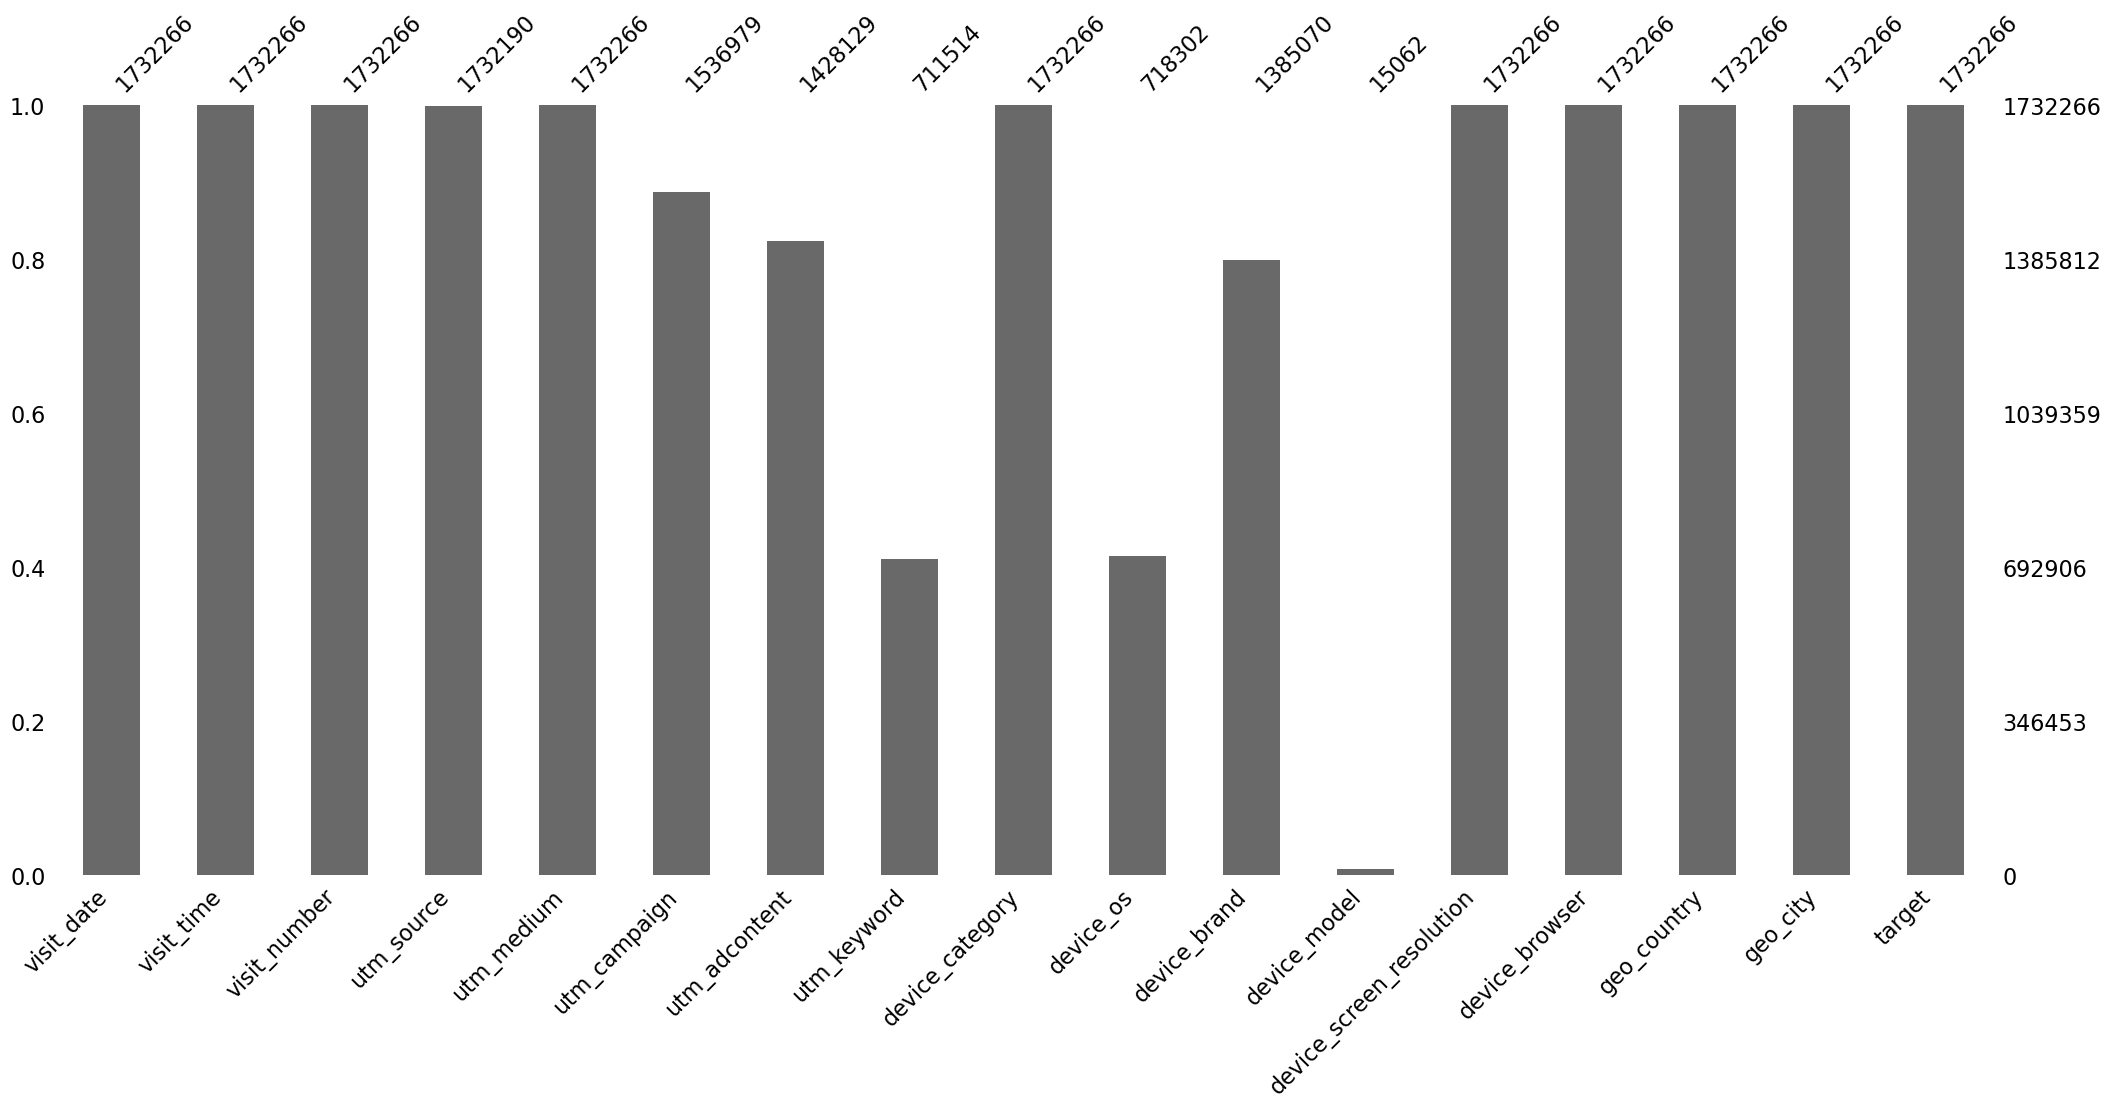

In [22]:
# Графическая иллюстрация пропусков.
msno.bar(df);

In [23]:
# Вывод информации по каждой колонке о количестве значений каждой категории и о количестве их уникальных значений.
# Периодически будет подсматривать в эту ячейку за информацией.
for column in df:    
    column_name = df[column]
    print(f"Характеристика: {column} \nКоличество уникальных значений: {column_name.nunique()} \nСписок значений: \n{column_name.value_counts(dropna=False)} \n")

Характеристика: visit_date 
Количество уникальных значений: 226 
Список значений: 
2021-05-24    39230
2021-12-21    29864
2021-05-25    19160
2021-06-29    16887
2021-09-14    15583
              ...  
2021-06-05     2032
2021-05-23     1109
2021-05-21      826
2021-05-22      761
2021-05-19      703
Name: visit_date, Length: 226, dtype: int64 

Характеристика: visit_time 
Количество уникальных значений: 85032 
Список значений: 
13:00:00    58044
12:00:00    57540
14:00:00    56824
10:00:00    56739
11:00:00    56270
            ...  
06:38:03        1
05:50:14        1
03:57:06        1
05:10:02        1
04:10:07        1
Name: visit_time, Length: 85032, dtype: int64 

Характеристика: visit_number 
Количество уникальных значений: 533 
Список значений: 
1      1301099
2       212176
3        71835
4        36600
5        21482
        ...   
417          1
418          1
420          1
421          1
564          1
Name: visit_number, Length: 533, dtype: int64 

Характеристика: utm_so

Характеристика: geo_country 
Количество уникальных значений: 159 
Список значений: 
Russia                 1682423
Ukraine                   8455
United States             8141
Belarus                   3432
Kazakhstan                2109
                        ...   
New Caledonia                1
Congo - Brazzaville          1
Rwanda                       1
Barbados                     1
Burundi                      1
Name: geo_country, Length: 159, dtype: int64 

Характеристика: geo_city 
Количество уникальных значений: 2389 
Список значений: 
Moscow              750928
Saint Petersburg    278402
(not set)            73297
Yekaterinburg        33555
Krasnodar            30260
                     ...  
Weesp                    1
Keila                    1
Winterthur               1
Boppard                  1
Pula                     1
Name: geo_city, Length: 2389, dtype: int64 

Характеристика: target 
Количество уникальных значений: 2 
Список значений: 
0    1681952
1      50314
N

##### Пропуски в  'device_model' и 'utm_keyword'

In [24]:
# Посмотрим на содержимое колонки 'device_model'.
df.device_model.unique()

array([nan, 'qBRdfuuhOnnqwSqNiPOv', 'AshpvdJdReafUzEMmWGr',
       'AuMdmADEIoPXiWpTsBEj', 'pcvPxfVFaAmhwFmvIeYd',
       'mzJXHtJPIOSHoHtgezIA', 'pTgAEPipQxDXCjPrJbHo',
       'IiVVIXFnNMwpBtuHILvS', 'FJApgTrMAGHoxCxQVKws',
       'tfPZFRbtlzEssBEesRwM', 'cwMJxNXiWUgMUxGiCTPs',
       'zFCiMWkbbAhTflrlLWnz', 'phrsMxwuvNvYsPYNbKkL',
       'QIRMJBHwssjlXzlheRfO', 'CwplVZElsIzdKfSTHwma',
       'auOrYtJwDXWlMwuBxhRC', 'kGgpyeEtacYWhzbuuWMR',
       'tWBQlsvNfHxRUjaPAfhd', 'HYwfQOXoovXynCsiUCVd',
       'mSVMBvlHFgftJaQAZEdp', 'kpwoWlshUwRtxMMtxukt',
       'opEZzhCrCCxqjKDmOcMK', 'FMeAKypVmqdjUhayrjne',
       'lOMpyAuAISPFiAxjXIYM', 'kjULrCjbRVbJtOfWpmQI',
       'adBSYqsJPBFluBxhXRzx', 'jXFxTkHxuiBKWOvUtsIa',
       'BhXucgFEfQMgSWpyKikP', 'ciZAODXEPQGDKvuEabGr',
       'bwQQjmDtGgrbnrREsYSG', 'JAIKWwxRffFOXQcfGTVi',
       'XoFyyEyrxZQbFrIVBGJU', 'oLPSmNOyoeTqtTUhnNIq',
       'wsPZygnUifLMgkSEnWLj', 'wOpkmMMUmanXnzWXmcFq',
       'DzXtLnggNbQSyyFLKlgY', 'eZRFfVvdAEANFDdbkujh',
     

In [25]:
# ... и колонки 'utm_keyword'.
df.utm_keyword.unique()

array(['puhZPIYqKXeFPaUviSjo', 'IGUCNvHlhfHpROGclCit', nan, ...,
       'aCaBoYaQJPVffhjBQnut', 'RaeBwzCLChMDgYYukNOw',
       'fcXWTQaKfxbkBkBnzLhK'], dtype=object)

In [26]:
# Информации, понятной человеку, которая могла бы пригодиться для заполнения пропусков в других колонках, нет. 
# Удаляем эти две колонки, так как процент пропущенных значений в них очень велик.
df = df.drop(columns=['device_model','utm_keyword'])
df.head()

,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,device_category,device_os,device_brand,device_screen_resolution,device_browser,geo_country,geo_city,target
0,2021-11-24,14:36:32,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,mobile,Android,Huawei,360x720,Chrome,Russia,Zlatoust,0
1,2021-11-14,08:21:30,1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,mobile,Android,Samsung,385x854,Samsung Internet,Russia,Moscow,0
2,2021-12-28,02:42:06,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,mobile,Android,Huawei,360x720,Chrome,Russia,Krasnoyarsk,0
3,2021-05-29,05:00:00,1,kjsLglQLzykiRbcDiGcD,cpc,NaN,NOBKLgtuvqYWkXQHeYWM,mobile,NaN,Xiaomi,393x786,Chrome,Russia,Moscow,0
4,2021-05-29,05:00:00,2,kjsLglQLzykiRbcDiGcD,cpc,NaN,NaN,mobile,NaN,Xiaomi,393x786,Chrome,Russia,Moscow,0


##### Пропуски в  'utm_source'

In [27]:
# Вывод значений колонки.
df.utm_source.unique()

array(['ZpYIoDJMcFzVoPFsHGJL', 'MvfHsxITijuriZxsqZqt',
       'kjsLglQLzykiRbcDiGcD', 'TxKUcPpthBDPieTGmVhx',
       'fDLlAcSmythWSCVMvqvL', 'gVRrcxiDQubJiljoTbGm',
       'SzZERoLMmrEUEhDaYcyN', 'BHcvLfOaCWvWTykYqHVe',
       'klTrhUaShgnjIbaPmqjc', 'ghoaGAksqhKomdFrxgyJ',
       'vFcAhRxLfOWKhvxjELkx', 'QxAxdyPLuQMEcrdZWdWb',
       'nSReTmyFtbSjlPrTKoaX', 'ISrKoXQCxqqYvAZICvjs',
       'hTjLvqNxGggkGnxSCaTm', 'RmEBuqrriAfAVsLQQmhk',
       'IZEXUFLARCUMynmHNBGo', 'bByPQxmDaMXgpHeypKSM',
       'jaSOmLICuBzCFqHfBdRg', 'PlbkrSYoHuZBWfYjYnfw',
       'dGlVSdmIlgWDyOPjfwwy', 'gDBGzjFKYabGgSPZvrDH',
       'NGNkCWwKgYFmiCCeZVxg', 'GpAkIXsclxDGyILfNlrR',
       'oZCzWSykfixnjMPDNjSU', 'dyicZQGoeASogoSafjEh',
       'fgymSoTvjKPEgaIJqsiH', 'aXQzDWsJuGXeBXexNHjc',
       'fbFKcMumlScApQMqFIqp', 'eLzNJHzPelJpEyBwMrKo',
       'ZHCJROlbqnkXTqIuVxnm', 'iNFgfQPqHPBuvGCYtrQE',
       'nmfptFmSirEqNzAzqbXA', 'maiZOsuEAMdeoRVsYoFk',
       'HbolMJUevblAbkHClEQa', 'cAqxcRdSSFAyCPUxQHqy',
       'Dn

In [28]:
# Количество пропусков.
df.utm_source.isna().sum()

76

In [29]:
# Заполним пропуски самым популярным значением.
df.utm_source = df.utm_source.fillna(df.utm_source.mode()[0])

In [30]:
# И убедимся, что пропусков больше нет.
df.utm_source.isna().sum()

0

##### Пропуски в 'utm_campaign' и 'utm_adcontent'

In [31]:
# Вывод значений 'utm_campaign'.
df.utm_campaign.unique()

array(['LEoPHuyFvzoNfnzGgfcd', 'FTjNLDyTrXaWYgZymFkV', nan,
       'LTuZkdKfxRGVceoWkVyg', 'gecBYcKZCPMcVYdSSzKP',
       'eimRuUrNhZLAYcwRrNXu', 'LwJZxKuWmvOhPsaCeRjG',
       'okTXSMadDkjvntEHzIjp', 'MXqmDyetMTICSSitTjWV',
       'PXQWdUxeUoXfoKzTBGpY', 'zxoiLxhuSIFrCeTLQVWZ',
       'nSReTmyFtbSjlPrTKoaX', 'BVKxkCOHKUOvkpbrLMgZ',
       'QEejXfOCtOMFLZqIPApp', 'kVOrIKZFrEYGvixPclal',
       'XHNUiSKKGTEpSAlaVMFQ', 'foFTSdUvNqqkPzZvgiqt',
       'SgIUDYUKnyWHVowUOqid', 'BAZCuyHZnaPrMGOMrcCQ',
       'bxOTvPtyGSdUrbwoXCPO', 'DXVdsSTQphSYVmRchYKt',
       'GWZGdHKPgmZPNPwkJshU', 'JwYIveaHVpeeRZloQCfF',
       'VBmazutCflYumtDHrQYe', 'UvuMsOSDBWQGOIbDbXfV',
       'RoDitORHdzGfGhNCyEMy', 'TmThBvoCcwkCZZUWACYq',
       'sbJRYgVfvcnqKJNDDYIr', 'XGYOaJEasWTwAKNdCGVX',
       'dMIPlIFgKzafYgowsqtp', 'EvhrtRzIJnQYHziPiLzV',
       'AqudXfUnmXWSDWVGYaXr', 'RxecHElWobBxIeAkqFXV',
       'hkvDVxqLOzGjGaoNiNzN', 'QdLfySaGXolfTBSNVfHn',
       'ULAUPJGgNiZYQgwZwZGR', 'JajANoFxoqXfKRNBUhzx',
     

In [32]:
# ... и значений 'utm_adcontent'.
df.utm_adcontent.unique()

array(['vCIpmpaGBnIQhyYNkXqp', 'xhoenQgDQsgfEPYNPwKO',
       'NOBKLgtuvqYWkXQHeYWM', nan, 'JNHcPlZPxEMWDnRiyoBf',
       'LcGIUNPUAmXtQJaDfFBR', 'NhvfEqcSTGEZKxxvUZlj',
       'LLfCasrxQzJIyuldcuWy', 'XKsYZiUFcdkUXQpoLKyS',
       'dUuXlWzvmhDSyclWRhNP', 'DZYjhfIUfdqhfuTNUmjn',
       'FkiRXDLOWtzVfvhEkhNo', 'TuyPWsGQruPMpKvRxeBF',
       'PkybGvWbaqORmxjNunqZ', 'UxrnyMlRBSOhOjytXnMG',
       'xnyHaukLtAvgViiZSyBC', 'ESUnXCsdWADovskBLvBO',
       'BdalQBXFeDGQTswaQtOL', 'SOkCdPxfUcZUzzOdgGES',
       'yYdBRbPmBMUZHXwqGxNx', 'AdeErYgVTbRcAWtHrMHq',
       'iyesFzGNBbKbSesPOuQt', 'lBvcHmZkKpwCXdgWSQYO',
       'XVKNbZXFFeCXocbAHwpS', 'SitoRrEOjouuWzzGooUa',
       'eOWmIGTKVDPewucDtZXG', 'aYAcKhelKzYpXrRYknSP',
       'nVzhCFmVaYpYhZVYHRhn', 'SAVVWaMghGnnvPOqMOIt',
       'lbhUYwMzoYJqJaUaTDba', 'LxluDbGsLnaemhTtGuvB',
       'OJiWyBKOyDITzXCZRSMH', 'qhEmhjPXvwgEHdBikgEQ',
       'XSkXBCPfnJjvxbfeewtd', 'EteMoEECGsaJeMnuvAZD',
       'WYLajZgbUhGimwBKDZUH', 'YTDFqIabKsQVGozQYoPf',
     

In [33]:
# Вывод количества пропусков в каждой из колонок и количества строк с пропусками одновременно в двух колонках.
print(df.utm_campaign.isna().sum())    
print(df.utm_adcontent.isna().sum())
print((df.utm_adcontent.isna() & df.utm_campaign.isna()).sum())

195287
304137
180463


In [34]:
# Видим, что, как правило, если пропуск есть в 'utm_campaign', то он есть и в 'utm_adcontent'.
# Заменим пропуски на значение 'other'.
df.utm_campaign = df.utm_campaign.fillna('other')
df.utm_adcontent = df.utm_adcontent.fillna('other')

In [35]:
# Убедимся, что пропусков не осталось.
print(df.utm_campaign.isna().sum())
print(df.utm_adcontent.isna().sum())

0
0


##### Пропуски / неинформативные значения в 'utm_medium'

In [36]:
# Вывод значений колонки 'utm_medium'.
df.utm_medium.unique()
# Вместо пропусков 'NaN' присутствуют значения '(none)' и '(not set)'.

array(['banner', 'cpm', 'cpc', 'organic', '(none)', 'referral', 'smm',
       'stories', 'blogger_channel', 'blogger_stories', 'email', 'app',
       'push', 'partner', 'tg', 'cpv', 'cpa', 'post', 'smartbanner',
       'info_text', 'outlook', 'clicks', 'landing', 'blogger_header',
       'qr', '(not set)', 'google_cpc', 'sms', 'article', 'vk_smm',
       'static', 'cbaafe', 'Sbol_catalog', 'fb_smm', 'landing_interests',
       'yandex_cpc', 'web_polka', 'ok_smm', 'linktest', 'sber_app', 'CPM',
       'medium', 'tablet', 'promo_sbol', 'reach', 'dom_click', 'nkp',
       'social', 'catalogue', 'main_polka', 'last', 'link', 'users_msk',
       'qrcodevideo', 'promo_sber'], dtype=object)

In [37]:
# Заменим только значения '(not set)' на моду (значение 'banner').
# Значения '(none)' оставим как есть, так как они пригодятся в дальнейшем при генерации признаков.
df.loc[(df.utm_medium=='(not set)'), 'utm_medium'] = df['utm_medium'].mode()[0]

In [38]:
# Удедимся, что всё отработало корректно.
df.utm_medium.value_counts()

banner               525611
cpc                  399395
(none)               277060
cpm                  229791
referral             136851
organic               55009
email                 28287
push                  27710
stories               10472
cpv                    7815
blogger_channel        7731
smartbanner            6501
blogger_stories        4226
tg                     3920
cpa                    3266
post                   2227
outlook                1269
app                    1211
smm                    1194
clicks                  908
blogger_header          760
info_text               335
sms                     194
landing                 127
partner                  95
link                     52
cbaafe                   43
CPM                      36
yandex_cpc               31
vk_smm                   25
static                   17
google_cpc               15
article                  15
web_polka                11
fb_smm                    8
medium              

##### Пропуски / неинформативные значения в 'device_brand'

In [39]:
# Вывод значений и их количества.
df.device_brand.value_counts(dropna=False)

Apple       503533
NaN         347196
Samsung     311641
Xiaomi      269251
Huawei      173828
             ...  
Star             1
Dell             1
Kenxinda         1
Hafury           1
Tanix            1
Name: device_brand, Length: 201, dtype: int64

In [40]:
# Посмотрим, с какими значениями из колонки 'device_os' (путём их перебора) соседствуют пропуски в 'device_brand'.
df[(df.device_brand.isna()) & (df.device_os=='Macintosh')]

,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,device_category,device_os,device_brand,device_screen_resolution,device_browser,geo_country,geo_city,target
215,2021-12-03,13:02:16,1,kjsLglQLzykiRbcDiGcD,cpc,XHNUiSKKGTEpSAlaVMFQ,JNHcPlZPxEMWDnRiyoBf,desktop,Macintosh,NaN,1440x900,Safari,Russia,Moscow,0
216,2021-12-03,13:02:19,2,kjsLglQLzykiRbcDiGcD,cpc,other,other,desktop,Macintosh,NaN,1440x900,Safari,Russia,Moscow,0
469,2021-11-03,10:45:43,1,kjsLglQLzykiRbcDiGcD,cpc,RoDitORHdzGfGhNCyEMy,other,desktop,Macintosh,NaN,1440x900,Chrome,Russia,(not set),1
470,2021-11-03,20:32:31,2,kjsLglQLzykiRbcDiGcD,cpc,RoDitORHdzGfGhNCyEMy,other,desktop,Macintosh,NaN,1440x900,Chrome,Russia,(not set),0
471,2021-11-04,13:40:22,3,kjsLglQLzykiRbcDiGcD,cpc,RoDitORHdzGfGhNCyEMy,other,desktop,Macintosh,NaN,1440x900,Chrome,Russia,(not set),0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1731890,2021-11-22,10:57:21,1,vFcAhRxLfOWKhvxjELkx,organic,okTXSMadDkjvntEHzIjp,LLfCasrxQzJIyuldcuWy,desktop,Macintosh,NaN,1920x1080,Chrome,Russia,Saint Petersburg,0
1731930,2021-10-29,17:28:19,1,jaSOmLICuBzCFqHfBdRg,email,bxOTvPtyGSdUrbwoXCPO,JNHcPlZPxEMWDnRiyoBf,desktop,Macintosh,NaN,1280x800,Chrome,Russia,Voronezh,0
1731976,2021-12-26,23:06:57,1,bByPQxmDaMXgpHeypKSM,referral,LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,desktop,Macintosh,NaN,1792x1120,Safari,Russia,Kursk,0
1732043,2021-09-24,16:59:05,1,jaSOmLICuBzCFqHfBdRg,email,YCKgTzTDywjcWyQudGch,nNqUcgFgcqQbTVSvgaHr,desktop,Macintosh,NaN,1792x1120,Safari,Russia,Moscow,0


In [41]:
# Если ОС - 'Macintosh', то бренд можно определить - 'Apple'. Произведем соответствующее заполнение.
df.loc[(df.device_brand.isna()) & (df.device_os=='Macintosh'), 'device_brand'] = 'Apple'

In [42]:
# Также путём перебора посмотрим, с какими значениями из колонки 'device_os' соседствуюет значение '(not set)' из 'device_brand'.
df[(df.device_brand=='(not set)') & (df.device_os=='iOS')]

,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,device_category,device_os,device_brand,device_screen_resolution,device_browser,geo_country,geo_city,target
26908,2021-11-08,16:47:53,2,kjsLglQLzykiRbcDiGcD,cpc,LwJZxKuWmvOhPsaCeRjG,other,mobile,iOS,(not set),414x896,Safari,Russia,Ryazan,0
900215,2021-11-18,02:31:39,1,kjsLglQLzykiRbcDiGcD,cpc,other,other,mobile,iOS,(not set),390x844,Safari,Russia,Moscow,0
1311882,2021-11-11,15:35:40,1,kjsLglQLzykiRbcDiGcD,cpc,other,other,mobile,iOS,(not set),375x812,Safari,Russia,Moscow,0
1392607,2021-12-17,06:54:33,1,kjsLglQLzykiRbcDiGcD,cpc,other,other,mobile,iOS,(not set),414x896,Safari,Russia,Moscow,0
1673884,2021-11-09,20:07:12,1,kjsLglQLzykiRbcDiGcD,cpc,other,other,mobile,iOS,(not set),375x667,Safari,Russia,Moscow,0


In [43]:
# Если ОС - 'iOs', то бренд можно определить - 'Apple'.
df.loc[(df.device_brand=='(not set)') & (df.device_os=='iOS'), 'device_brand'] = 'Apple'

In [44]:
# Если ОС - 'Tizen', то бренд - 'Samsung'.
df.loc[(df.device_brand=='(not set)') & (df.device_os=='Tizen'), 'device_brand'] = 'Samsung'

In [45]:
# Также можно найти недостающую информацию в колонке 'device_browser'.
df[(df.device_brand.isna()) & (df.device_browser=='Samsung Internet')]

,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,device_category,device_os,device_brand,device_screen_resolution,device_browser,geo_country,geo_city,target
4292,2021-11-08,16:29:06,3,bByPQxmDaMXgpHeypKSM,referral,bxOTvPtyGSdUrbwoXCPO,JNHcPlZPxEMWDnRiyoBf,desktop,Linux,NaN,712x1138,Samsung Internet,Russia,Korolyov,0
15710,2021-08-15,03:00:00,1,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,desktop,NaN,NaN,1280x800,Samsung Internet,Russia,Kazan,0
38200,2021-11-27,13:00:29,1,BHcvLfOaCWvWTykYqHVe,cpc,other,other,desktop,Linux,NaN,800x1334,Samsung Internet,Russia,Moscow,0
56752,2021-09-25,10:00:00,1,RmEBuqrriAfAVsLQQmhk,cpc,VBmazutCflYumtDHrQYe,JNHcPlZPxEMWDnRiyoBf,desktop,NaN,NaN,1334x800,Samsung Internet,Russia,Saint Petersburg,0
56753,2021-09-25,12:00:00,2,RmEBuqrriAfAVsLQQmhk,cpc,VBmazutCflYumtDHrQYe,JNHcPlZPxEMWDnRiyoBf,desktop,NaN,NaN,1334x800,Samsung Internet,Russia,Saint Petersburg,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1724431,2021-05-29,00:00:00,1,kjsLglQLzykiRbcDiGcD,cpc,iNaIAFVuZgYukekFQQbX,vIKILzdGQEEbEpgPefxF,tablet,NaN,NaN,960x600,Samsung Internet,Russia,Saint Petersburg,0
1724432,2021-05-29,00:00:00,2,kjsLglQLzykiRbcDiGcD,cpc,iNaIAFVuZgYukekFQQbX,vIKILzdGQEEbEpgPefxF,tablet,NaN,NaN,960x600,Samsung Internet,Russia,Saint Petersburg,0
1725363,2021-07-20,18:00:00,2,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,desktop,NaN,NaN,412x915,Samsung Internet,Russia,Saint Petersburg,0
1728422,2021-12-07,19:50:30,1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,desktop,Linux,NaN,360x640,Samsung Internet,Russia,Moscow,0


In [46]:
# Если браузер - 'Samsung Internet', то бренд - 'Samsung'. Произведем соответствующие заполнения.
df.loc[(df.device_brand.isna()) & (df.device_browser=='Samsung Internet'), 'device_brand'] = 'Samsung'
df.loc[(df.device_brand=='(not set)') & (df.device_browser=='Samsung Internet'), 'device_brand'] = 'Samsung'

In [47]:
# Если браузер - 'Safari' или 'Safari (in-app)', то бренд - 'Apple'.
df.loc[(df.device_brand.isna()) & ((df.device_browser=='Safari') | (df.device_browser=='Safari (in-app)')), 'device_brand'] = 'Apple'
df.loc[(df.device_brand=='(not set)') & ((df.device_browser=='Safari') | (df.device_browser=='Safari (in-app)')), 'device_brand'] = 'Apple'

In [48]:
# Заменим оставшиеся пропуски и '(not set)' на значения 'unknown'.
df.device_brand = df.device_brand.fillna('unknown')
df.loc[(df.device_brand=='(not set)'), 'device_brand'] = 'unknown'

In [49]:
# Удедимся, что изменения произошли.
df.device_brand.value_counts(dropna=False)

Apple        553064
unknown      313439
Samsung      312259
Xiaomi       269251
Huawei       173828
              ...  
Kenxinda          1
Mobiistar         1
Fero              1
Dell              1
Tanix             1
Name: device_brand, Length: 200, dtype: int64

##### Пропуски / неинформативные значения в 'device_os'

In [50]:
# Вывод значений и их количества
df.device_os.value_counts(dropna=False)

NaN              1013964
Android           425520
iOS               182597
Windows            81740
Macintosh          23415
Linux               4616
(not set)            309
Chrome OS             65
BlackBerry            24
Tizen                  7
Firefox OS             3
Windows Phone          2
Nokia                  2
Samsung                2
Name: device_os, dtype: int64

In [51]:
# Пропуски можно заполнить, взяв достоверную информацию из колонок 'device_brand' и 'device_browser'.
# Также помним про значения '(not set)', которые также можно заполнить из указанных выше колонок (при наличии пересечений).
df[(df.device_os.isna()) & ((df.device_brand=='Apple') | (df.device_browser=='Safari') | (df.device_browser=='Safari (in-app)'))]

,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,device_category,device_os,device_brand,device_screen_resolution,device_browser,geo_country,geo_city,target
5,2021-05-31,12:00:00,1,kjsLglQLzykiRbcDiGcD,organic,LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,mobile,NaN,Apple,375x812,Safari,Russia,Saint Petersburg,0
32,2021-08-08,22:00:00,1,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,tablet,NaN,Apple,375x667,Safari (in-app),Russia,Moscow,0
33,2021-08-08,22:00:00,2,klTrhUaShgnjIbaPmqjc,referral,LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,tablet,NaN,Apple,375x667,Safari (in-app),Russia,Moscow,0
34,2021-07-27,13:00:00,1,ghoaGAksqhKomdFrxgyJ,cpm,FTjNLDyTrXaWYgZymFkV,NhvfEqcSTGEZKxxvUZlj,mobile,NaN,Apple,375x812,Safari (in-app),Russia,Vladivostok,0
44,2021-07-15,05:00:00,1,ZpYIoDJMcFzVoPFsHGJL,banner,MXqmDyetMTICSSitTjWV,JNHcPlZPxEMWDnRiyoBf,mobile,NaN,Apple,428x926,Safari,United States,Sunny Isles Beach,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1732230,2021-10-01,09:00:00,1,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,mobile,NaN,Apple,414x896,Safari,Russia,Saint Petersburg,0
1732241,2021-08-15,23:00:00,1,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,mobile,NaN,Apple,428x926,Safari (in-app),Russia,Moscow,0
1732242,2021-08-16,08:00:00,2,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,mobile,NaN,Apple,428x926,Safari (in-app),Russia,Moscow,0
1732259,2021-08-29,14:00:00,1,ISrKoXQCxqqYvAZICvjs,blogger_stories,zfwIehuEfWYdYrEZgRLo,JNHcPlZPxEMWDnRiyoBf,mobile,NaN,Apple,414x896,Safari,Russia,Zheleznodorozhny,0


In [52]:
# Если бренд - 'Apple' или браузер - 'Safari', укажем в пропусках 'iOS'.
df.loc[(df.device_os.isna()) & ((df.device_brand=='Apple') | (df.device_browser=='Safari') | (df.device_browser=='Safari (in-app)')), 'device_os'] = 'iOS'

In [53]:
# Если браузер 'Edge' или 'Internet Explorer', то операционная система - 'Windows'.
df.loc[(df.device_os.isna()) & ((df.device_browser=='Edge') | (df.device_browser=='Internet Explorer')), 'device_os'] = 'Windows'

In [54]:
# Заменим оставшиеся пропуски и '(not set)' на значения 'Android'.
df.device_os = df.device_os.fillna('Android')
df.loc[(df.device_os=='(not set)'), 'device_os'] = 'Android'

In [55]:
# Удедимся, что изменения произошли.
df.device_os.value_counts(dropna=False)

Android          1083319
iOS               529648
Windows            91163
Macintosh          23415
Linux               4616
Chrome OS             65
BlackBerry            24
Tizen                  7
Firefox OS             3
Windows Phone          2
Nokia                  2
Samsung                2
Name: device_os, dtype: int64

In [56]:
# Удедимся, что пропусков в датасете не оставлось.
df.isna().sum()

visit_date                  0
visit_time                  0
visit_number                0
utm_source                  0
utm_medium                  0
utm_campaign                0
utm_adcontent               0
device_category             0
device_os                   0
device_brand                0
device_screen_resolution    0
device_browser              0
geo_country                 0
geo_city                    0
target                      0
dtype: int64

### Объединение мелких категорий в категориальных признаках

##### В 'utm_source'

In [57]:
# Подсчет количества значений.
df.utm_source.value_counts()

ZpYIoDJMcFzVoPFsHGJL    552631
fDLlAcSmythWSCVMvqvL    277060
kjsLglQLzykiRbcDiGcD    245178
MvfHsxITijuriZxsqZqt    175831
BHcvLfOaCWvWTykYqHVe    110963
                         ...  
tYfqTBjAxWbmBruissGm         1
RzLAoRYmCtVATSoPvWAQ         1
sbJRYgVfvcnqKJNDDYIr         1
LigOnUObPodLDexszDtn         1
yjIcHowrPNcMWjOzgULE         1
Name: utm_source, Length: 280, dtype: int64

In [58]:
# Категории с количеством значений менее 150.
df.utm_source.value_counts().loc[lambda x : x < 150]

QzPMrfYhYSLYYPtPaBxI    147
MYrKypXYDhDVwJMUhCqu    140
NwuIyBhuPCXhJVPLtXCC    130
HbolMJUevblAbkHClEQa    126
vNNYHvZtTVtJICHsjBBL    124
                       ... 
tYfqTBjAxWbmBruissGm      1
RzLAoRYmCtVATSoPvWAQ      1
sbJRYgVfvcnqKJNDDYIr      1
LigOnUObPodLDexszDtn      1
yjIcHowrPNcMWjOzgULE      1
Name: utm_source, Length: 224, dtype: int64

In [59]:
# Создание списка категорий с количеством значений менее 150.
lst = df.utm_source.value_counts().loc[lambda x : x < 150].index.tolist()
lst

['QzPMrfYhYSLYYPtPaBxI',
 'MYrKypXYDhDVwJMUhCqu',
 'NwuIyBhuPCXhJVPLtXCC',
 'HbolMJUevblAbkHClEQa',
 'vNNYHvZtTVtJICHsjBBL',
 'WeIwsqEbpZGZwhcQktNS',
 'DlnuGwaJBHGNEKdWfOpe',
 'LlBOVIARRTjfgnQNjJre',
 'dGlVSdmIlgWDyOPjfwwy',
 'YECMcEASiXejEJmgUmEG',
 'CFeqZLBNQdYHxJrTOHjY',
 'IsHcZJuNYwanAAEDxuOE',
 'fcXWTQaKfxbkBkBnzLhK',
 'eYRDXZIocNyHVjEHzesr',
 'CgsxHpdTmXHvrHqEKRxp',
 'RVKHNCFOYpjJjjAtwCgE',
 'QYfbqJXuLdJGfOSFgZOs',
 'ZSALOpDDuJdQyGxrsDWn',
 'LIWKeifdTCbuNeniIUqm',
 'maiZOsuEAMdeoRVsYoFk',
 'ySpKPVDYCgmkHVSeLjnJ',
 'WiILFRDQbcHDHNvHzGpX',
 'GWZGdHKPgmZPNPwkJshU',
 'MQvSjpHGoGjbcBjfnLLm',
 'bgTYkDHjOsJzMUtoGhiQ',
 'tzIeQUUHahhBuEkJqDVp',
 'vEBWkLmuIpqNdxZZdlnW',
 'wlyUPieAGrQNIlkbmySd',
 'EvhrtRzIJnQYHziPiLzV',
 'bxOTvPtyGSdUrbwoXCPO',
 'pvCdohkUBGPPZOsCzVAu',
 'oSQBbhIkNionRJpNbQfT',
 'NTQAiqAhSTbkRRmxVKoQ',
 'xQnKzPSrehWizZOmwHkM',
 'IRGUHqwEMepMjgCYBVRn',
 'mNTexKeDdCADhrBgkEeA',
 'rgsINTLYFsElIlfRtNDP',
 'zhqxcsahQYAzJvRzebNp',
 'eTMcXJUftGtjDdKkZmfy',
 'OtrdXnwzWFjzhNlHVLfd',


In [60]:
# Создание новой колонки 'utm_source_upd' с присвоением категориям из списка lst значения 'rare'.
df['utm_source_upd'] = df.apply(lambda x: 'rare' if x.utm_source in lst else x.utm_source, axis=1)

In [61]:
# Количество уникальных значений новой колонки.
df.utm_source_upd.nunique()

57

##### В 'utm_medium'

In [62]:
# Подсчет количества значений.
df.utm_medium.value_counts()

banner               525611
cpc                  399395
(none)               277060
cpm                  229791
referral             136851
organic               55009
email                 28287
push                  27710
stories               10472
cpv                    7815
blogger_channel        7731
smartbanner            6501
blogger_stories        4226
tg                     3920
cpa                    3266
post                   2227
outlook                1269
app                    1211
smm                    1194
clicks                  908
blogger_header          760
info_text               335
sms                     194
landing                 127
partner                  95
link                     52
cbaafe                   43
CPM                      36
yandex_cpc               31
vk_smm                   25
static                   17
google_cpc               15
article                  15
web_polka                11
fb_smm                    8
medium              

In [63]:
# Создание списка категорий с количеством значений менее 120.
lst = df.utm_medium.value_counts().loc[lambda x : x < 120].index.tolist()
lst

['partner',
 'link',
 'cbaafe',
 'CPM',
 'yandex_cpc',
 'vk_smm',
 'static',
 'google_cpc',
 'article',
 'web_polka',
 'fb_smm',
 'medium',
 'ok_smm',
 'nkp',
 'social',
 'catalogue',
 'main_polka',
 'promo_sber',
 'reach',
 'users_msk',
 'linktest',
 'sber_app',
 'promo_sbol',
 'tablet',
 'dom_click',
 'Sbol_catalog',
 'landing_interests',
 'last',
 'qrcodevideo',
 'qr']

In [64]:
# Создание новой колонки 'utm_medium_upd' с присвоением категориям из списка lst значения 'rare'.
df['utm_medium_upd'] = df.apply(lambda x: 'rare' if x.utm_medium in lst else x.utm_medium, axis=1)

In [65]:
# Количество уникальных значений новой колонки.
df.utm_medium_upd.nunique()

25

##### В 'utm_campaign'

In [66]:
# Подсчет количества значений.
df.utm_campaign.value_counts()

LTuZkdKfxRGVceoWkVyg    422992
LEoPHuyFvzoNfnzGgfcd    321286
FTjNLDyTrXaWYgZymFkV    234950
other                   195287
gecBYcKZCPMcVYdSSzKP    133247
                         ...  
mfMzuDnnxZoVzgSxUxeJ         1
ZHCJROlbqnkXTqIuVxnm         1
JkhCpeDGCtTwhwqWLywv         1
KLznuVEblkSupUDWtCge         1
HXlcbndflGLufMTnkOso         1
Name: utm_campaign, Length: 407, dtype: int64

In [67]:
# Создание списка категорий с количеством значений менее 400.
lst = df.utm_campaign.value_counts().loc[lambda x : x < 400].index.tolist()
lst

['hBWmNYrvNzCBHuiQQxfV',
 'RzLAoRYmCtVATSoPvWAQ',
 'qjmBmKWCivQiONdxBwQN',
 'RwJRitibjRveidvwKiLL',
 'EcEOnwFpCaiUbrbFLICY',
 'qpUkxmFZPYAfFrViyYab',
 'hnthrvdBdqpbZrLTWFSs',
 'yCnTwlCLkqZHwAglrEll',
 'jXKhPqSdMbcUvJsaNCVA',
 'MvfHsxITijuriZxsqZqt',
 'DBLWVjTjVZuzWYWTaDfZ',
 'nmfptFmSirEqNzAzqbXA',
 'WZxCpdfLzrgIfGUqxGpE',
 'aPqwsNrUDOqqlOPbgStP',
 'jpjTolpOezlrOPAunDZi',
 'KGpIIoFhRfLgffkknBkK',
 'kzqtiVtETHDUrZfgudlz',
 'agnCWMgbwJZgTVVsuCLg',
 'gkrlxvSUaPCJLtsTAaHI',
 'xGRbRuBkKsQPkKARPeOn',
 'KiQeSeROtpITKBTCBZpa',
 'TzXEvSoFiirteePaCzeY',
 'KTPxKBplKCicmchTWoPH',
 'nGFPxtyrBsOYBtJhrWEk',
 'vuriSCpYEnMEbLACpaMZ',
 'quxdQHtdlpFZfBZSiXFZ',
 'HKUDoNXhPeIzUdnZpRdl',
 'PuSsXRwSpZeHuyXoHqhm',
 'mpFygdnCzMsVlLWOpHBn',
 'NLWjXuYiXlKrFJfSWfKt',
 'rcPTSYUkeyIdANHAzyqt',
 'VzoFtfHotWfgMqOvhhpk',
 'BtHktUgMgEVIjKWdCrLZ',
 'aCaBoYaQJPVffhjBQnut',
 'yEzOkUNmavmsRTXaISLf',
 'TBuBeLHkANSfemZzCoVD',
 'ydXTgkwKyFWEAJoahduP',
 'ukwEyFczbqbKStCfJGsY',
 'vDDUOyLFNAxxxTqPIvmu',
 'LJZfurSmjxvomWxSCcZR',


In [68]:
# Создание новой колонки 'utm_campaign_upd' с присвоением категориям из списка lst значения 'rare'.
df['utm_campaign_upd'] = df.apply(lambda x: 'rare' if x.utm_campaign in lst else x.utm_campaign, axis=1)

In [69]:
# Количество уникальных значений новой колонки.
df.utm_campaign_upd.nunique()

118

##### В 'utm_adcontent'

In [70]:
# Подсчет количества значений.
df.utm_adcontent.value_counts()

JNHcPlZPxEMWDnRiyoBf    935408
other                   304137
vCIpmpaGBnIQhyYNkXqp    179438
xhoenQgDQsgfEPYNPwKO    104381
PkybGvWbaqORmxjNunqZ     59038
                         ...  
mxvgMizBAnQXeqzHjTwa         1
IcLcclbnECGqvCQgOdET         1
ESMghHbAVcqVsGPVpygd         1
zQEFTgQvqExfbldEpotc         1
EsbpyHMkFkavykEeYhch         1
Name: utm_adcontent, Length: 281, dtype: int64

In [71]:
# Создание списка категорий с количеством значений менее 150.
lst = df.utm_adcontent.value_counts().loc[lambda x : x < 150].index.tolist()
lst

['WbmadpYgwtVCcAwGJoXb',
 'jpZoxCaowxXvglZVUJyq',
 'sDWYAbLNiGZVxGBDdTxc',
 'rqvMZiqGRTZpxvRSUTzX',
 'yEzOkUNmavmsRTXaISLf',
 'QEPLWgIvqPEGXcwBrsFw',
 'WvCMRUAbanZQkQfWaSEa',
 'WflCDYRNXOTCqRqynqbH',
 'NacUSAyeXYJDflPqmJGg',
 'hrqYkXkJsxqBbbPugYJm',
 'jydEWYUtqCvdQucWTOqa',
 'togKdkbomlWcHNkZFveU',
 'GyxYpYhQwOKlCntiPTSL',
 'QCjbxkecYPvHpsJxBXej',
 'htRZUQDANvNrHaxZjsjz',
 'ptYJgYxtYQLiZcgpjmXe',
 'lbhUYwMzoYJqJaUaTDba',
 'AREbWGOhRGJXAffGqZTc',
 'ePOwRDMsDnhYErGgxfUz',
 'xLqUcIHZLQWTXrgoxpZY',
 'cwJiQIYIVtjAceFuhkSu',
 'CxCBGzPzbDmiZjhHYhSs',
 'jGIBHItAWSMJqMByEHbB',
 'NUkWLMZGFsiVUNEECwyd',
 'qMvKVRkKgfEwmAJomJUe',
 'MGmjaIrUtTBPOkAewtqx',
 'ZbhjTfTaZOUpHAHHpvsP',
 'FNSBWzZNPqRWMLiASvpg',
 'QXCBxPuOCSEEHrqrweFV',
 'ZIMljraejFHmkkHvoNxk',
 'OCpaogbJxWDpWXDqfzPq',
 'zpkCOCjptAAOxrlaKYsq',
 'vbzpJSRWauYxaFMVEbfb',
 'LIWKeifdTCbuNeniIUqm',
 'nXyOBtEiCStSWKCRhcaM',
 'tCLxWkPNVjjdHjETjiXL',
 'BAPjRoSMBzueRDVKzGzo',
 'ODLcVlzKCdodjHQNkIoL',
 'JKvVAMEfeoNMSMFzAAfE',
 'nLphJBcyVYYXooJVlUxu',


In [72]:
# Создание новой колонки 'utm_adcontent_upd' с присвоением категориям из списка lst значения 'rare'.
df['utm_adcontent_upd'] = df.apply(lambda x: 'rare' if x.utm_adcontent in lst else x.utm_adcontent, axis=1)

In [73]:
# Количество уникальных значений новой колонки.
df.utm_adcontent_upd.nunique()

72

##### В 'device_brand'

In [74]:
# Подсчет количества значений.
df.device_brand.value_counts()

Apple        553064
unknown      313439
Samsung      312259
Xiaomi       269251
Huawei       173828
              ...  
Kenxinda          1
Mobiistar         1
Fero              1
Dell              1
Tanix             1
Name: device_brand, Length: 200, dtype: int64

In [75]:
# Создание списка категорий с количеством значений менее 70.
lst = df.device_brand.value_counts().loc[lambda x : x < 70].index.tolist()
lst

['Karbonn',
 'LeTV',
 'Highscreen',
 'Coolpad',
 'AGM',
 'Acer',
 'Haier',
 'Black Fox',
 'Mito',
 'Teclast',
 'Fly',
 'Chuwi',
 'iNew',
 'Vernee',
 'Kyocera',
 'Nomu',
 'Nuu',
 'Wiko',
 'Elephone',
 'Kingplay',
 'Gionee',
 'SonyEricsson',
 'Digma',
 'Smartisan',
 'NOA',
 'Alldocube',
 'BLU',
 'General Mobile',
 'Kata',
 'Tele2',
 'Symphony',
 'ZOJI',
 'Amazon',
 'Celkon',
 'Lava',
 'Pantech',
 'Irbis',
 'Gome',
 'QMobile',
 'E&L',
 'Ark',
 'Yota Devices',
 'Condor',
 'Komu',
 'Flexymove',
 'Poptel',
 'Razer',
 'Ananda',
 'Wigor',
 'Oysters',
 'MTC',
 'China Phone',
 'Billion',
 'Artel',
 'Explay',
 'BLUBOO',
 'Iris',
 'ThL',
 'INUI',
 'A1',
 'MediaTek',
 'Unihertz',
 'InFocus',
 'Geotel',
 'Jiake',
 'SenseIT',
 'Caterpillar',
 'InnJoo',
 'China Mobile',
 'Guophone',
 'Essential',
 'Keecoo',
 'Panasonic',
 'H96',
 'Vertu',
 'Xgody',
 'Vestel',
 'Land Rover',
 'TurboPad',
 'Fujitsu',
 'MXQ',
 'Fairphone',
 'Evercoss',
 'Archos',
 'AT&T',
 'Qbex',
 'Yuntab',
 'Advan',
 'Dynamic',
 'UMI',

In [76]:
# Создание новой колонки 'device_brand_upd' с присвоением категориям из списка lst значения 'rare'.
df['device_brand_upd'] = df.apply(lambda x: 'rare' if x.device_brand in lst else x.device_brand, axis=1)

In [77]:
# Количество уникальных значений новой колонки.
df.device_brand_upd.nunique()

51

##### В 'device_browser'

In [78]:
# Подсчет количества значений.
df.device_browser.value_counts()

Chrome                              951573
Safari                              436705
YaBrowser                           123765
Safari (in-app)                      65952
Android Webview                      51919
Samsung Internet                     44273
Opera                                25094
Firefox                              15738
Edge                                 15196
UC Browser                             815
Mozilla Compatible Agent               336
Android Runtime                        241
[FBAN                                  115
MRCHROME                                72
Instagram 208.0.0.32.135 Android        72
Instagram 209.0.0.21.119 Android        49
Android Browser                         47
Puffin                                  43
Maxthon                                 30
Internet Explorer                       24
Opera Mini                              23
Android                                 19
Instagram 202.0.0.23.119                17
Mozilla    

In [79]:
# Создание списка категорий с количеством значений менее 100.
lst = df.device_browser.value_counts().loc[lambda x : x < 100].index.tolist()
lst

['MRCHROME',
 'Instagram 208.0.0.32.135 Android',
 'Instagram 209.0.0.21.119 Android',
 'Android Browser',
 'Puffin',
 'Maxthon',
 'Internet Explorer',
 'Opera Mini',
 'Android',
 'Instagram 202.0.0.23.119',
 'Mozilla',
 'Instagram 194.0.0.36.172 Android',
 'Instagram 202.0.0.37.123 Android',
 '(not set)',
 'com.vk.vkclient',
 'Amazon Silk',
 'Coc Coc',
 'Instagram 212.0.0.38.119 Android',
 'Instagram 192.0.0.37.119',
 'Instagram 203.0.0.26.117',
 'helloworld',
 'Instagram 201.0.0.23.111',
 'Instagram 207.0.0.28.118',
 'Instagram 216.1.0.21.137 Android',
 'Instagram 216.0.0.12.135',
 'Instagram 213.0.0.29.120 Android',
 'Instagram 213.0.0.19.117',
 'Instagram 192.0.0.35.123 Android',
 'Instagram 158.0.0.30.123 Android',
 'SeaMonkey',
 'Instagram 199.1.0.34.119 Android',
 'NetFront',
 'Instagram 208.0.0.26.131',
 'Iron',
 'Instagram 199.0.0.27.120',
 'MyApp',
 'Nokia501',
 'Threads 202.0.0.23.119',
 'com.zhiliaoapp.musically',
 'Konqueror',
 'NokiaX2-02',
 'MT6735_TD']

In [80]:
# Создание новой колонки 'device_browser_upd' с присвоением категориям из списка lst значения 'rare'.
df['device_browser_upd'] = df.apply(lambda x: 'rare' if x.device_browser in lst else x.device_browser, axis=1)

In [81]:
# Количество уникальных значений новой колонки.
df.device_browser_upd.nunique()

14

##### Просмотр результатов объединения категорий

In [82]:
# Размерность датафрейма после добавления новых колонок.
df.shape

(1732266, 21)

In [83]:
# Cоздание таблицы с результатами объединения категорий.
sheet = pd.DataFrame({'column': ['utm_source', 'utm_medium', 'utm_campaign', 'utm_adcontent', 'device_brand', 'device_browser'],
                      'quantity_limit': [150, 120, 400, 150, 70, 100],
                      'n_categories_before': [280, 54, 407, 281, 200, 55],
                      'n_categories_after': [57, 25, 118, 72, 51, 14]})
sheet

,column,quantity_limit,n_categories_before,n_categories_after
0,utm_source,150,280,57
1,utm_medium,120,54,25
2,utm_campaign,400,407,118
3,utm_adcontent,150,281,72
4,device_brand,70,200,51
5,device_browser,100,55,14


In [84]:
# Удалим колонки, которые использовали для создания новых, и которые нам больше не пригодятся.
df = df.drop(columns=['utm_source', 'utm_medium', 'utm_campaign', 'utm_adcontent', 'device_brand', 'device_browser'])
df.head()

,visit_date,visit_time,visit_number,device_category,device_os,device_screen_resolution,geo_country,geo_city,target,utm_source_upd,utm_medium_upd,utm_campaign_upd,utm_adcontent_upd,device_brand_upd,device_browser_upd
0,2021-11-24,14:36:32,1,mobile,Android,360x720,Russia,Zlatoust,0,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,Huawei,Chrome
1,2021-11-14,08:21:30,1,mobile,Android,385x854,Russia,Moscow,0,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,Samsung,Samsung Internet
2,2021-12-28,02:42:06,1,mobile,Android,360x720,Russia,Krasnoyarsk,0,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,Huawei,Chrome
3,2021-05-29,05:00:00,1,mobile,Android,393x786,Russia,Moscow,0,kjsLglQLzykiRbcDiGcD,cpc,other,NOBKLgtuvqYWkXQHeYWM,Xiaomi,Chrome
4,2021-05-29,05:00:00,2,mobile,Android,393x786,Russia,Moscow,0,kjsLglQLzykiRbcDiGcD,cpc,other,other,Xiaomi,Chrome


# Feature engineering

##### На основе 'visit_date' и 'visit_time'

In [85]:
# Приведем колонку 'visit_date' к типу 'datetime'.
df['visit_date'] = pd.to_datetime(df['visit_date'])

In [86]:
# Создадим новый признак 'month' (месяц).
df['month'] = df['visit_date'].dt.month
df['month']

0          11
1          11
2          12
3           5
4           5
           ..
1732261    12
1732262     5
1732263    11
1732264    11
1732265    12
Name: month, Length: 1732266, dtype: int64

In [87]:
# Новый признак 'day_of_month' (день месяца).
df['day_of_month'] = df['visit_date'].dt.day
df['day_of_month']

0          24
1          14
2          28
3          29
4          29
           ..
1732261    22
1732262    26
1732263    15
1732264    29
1732265    31
Name: day_of_month, Length: 1732266, dtype: int64

In [88]:
# Новый признак 'day_of_week' (день недели).
df['day_of_week'] = df['visit_date'].dt.dayofweek
df['day_of_week']

0          2
1          6
2          1
3          5
4          5
          ..
1732261    2
1732262    2
1732263    0
1732264    0
1732265    4
Name: day_of_week, Length: 1732266, dtype: int64

In [89]:
# Убедимся, что все значения колонки 'visit_time' содержат символ ':', по которому можно произвести разделение.
df.visit_time.str.contains(':').describe()

count     1732266
unique          1
top          True
freq      1732266
Name: visit_time, dtype: object

In [90]:
# Создадим новый признак 'hour_of_day' (час дня).
df['hour_of_day'] = df.visit_time.apply(lambda x: x.split(':')[0]).astype(int)
df['hour_of_day']

0          14
1           8
2           2
3           5
4           5
           ..
1732261    10
1732262     8
1732263    15
1732264    15
1732265    19
Name: hour_of_day, Length: 1732266, dtype: int32

In [91]:
# Удалим колонки, котрые использовали для генерации новых признаков.
df = df.drop(columns=['visit_date','visit_time'])
df.head()

,visit_number,device_category,device_os,device_screen_resolution,geo_country,geo_city,target,utm_source_upd,utm_medium_upd,utm_campaign_upd,utm_adcontent_upd,device_brand_upd,device_browser_upd,month,day_of_month,day_of_week,hour_of_day
0,1,mobile,Android,360x720,Russia,Zlatoust,0,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,Huawei,Chrome,11,24,2,14
1,1,mobile,Android,385x854,Russia,Moscow,0,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,Samsung,Samsung Internet,11,14,6,8
2,1,mobile,Android,360x720,Russia,Krasnoyarsk,0,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,Huawei,Chrome,12,28,1,2
3,1,mobile,Android,393x786,Russia,Moscow,0,kjsLglQLzykiRbcDiGcD,cpc,other,NOBKLgtuvqYWkXQHeYWM,Xiaomi,Chrome,5,29,5,5
4,2,mobile,Android,393x786,Russia,Moscow,0,kjsLglQLzykiRbcDiGcD,cpc,other,other,Xiaomi,Chrome,5,29,5,5


##### На основе 'device_screen_resolution'

In [92]:
# Убедимся, что все значения колонки 'device_screen_resolution' содержат символ 'x', по которому можно произвести разделение.
df.device_screen_resolution.str.contains('x').describe()

count     1732266
unique          1
top          True
freq      1732266
Name: device_screen_resolution, dtype: object

In [93]:
# Сгенерируем признак 'screen_width' (ширина экрана).
df['screen_width'] = df.device_screen_resolution.apply(lambda x: x.split('x')[0]).astype(int)
df['screen_width']

0           360
1           385
2           360
3           393
4           393
           ... 
1732261    1920
1732262     390
1732263     375
1732264     393
1732265    1366
Name: screen_width, Length: 1732266, dtype: int32

In [94]:
# Отсортируем значения, чтобы увидеть самые малые и самые большие.
df['screen_width'].sort_values()

917653        0
108556        0
250224        0
753209        0
434853        0
           ... 
774191     5760
241296     5760
241297     5760
1466164    5924
358021     5924
Name: screen_width, Length: 1732266, dtype: int32

In [95]:
# Выведем строки с самыми большими значениями признака.
# Убедимся, что это не выбросы, а вполне реальные значения.
df[(df['screen_width'] > 5120)]

,visit_number,device_category,device_os,device_screen_resolution,geo_country,geo_city,target,utm_source_upd,utm_medium_upd,utm_campaign_upd,utm_adcontent_upd,device_brand_upd,device_browser_upd,month,day_of_month,day_of_week,hour_of_day,screen_width
241296,1,desktop,Android,5760x1080,Russia,Samara,0,bByPQxmDaMXgpHeypKSM,referral,LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,unknown,Chrome,10,5,1,8,5760
241297,2,desktop,Android,5760x1080,Russia,Samara,0,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,unknown,Chrome,10,5,1,13,5760
358021,1,desktop,Android,5924x1080,Russia,(not set),0,PlbkrSYoHuZBWfYjYnfw,cpm,FTjNLDyTrXaWYgZymFkV,TuyPWsGQruPMpKvRxeBF,unknown,Opera,7,15,3,5,5924
774191,1,desktop,Android,5760x1080,Russia,Samara,0,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,unknown,Chrome,7,13,1,16,5760
1466164,1,desktop,Android,5924x1080,Russia,(not set),0,PlbkrSYoHuZBWfYjYnfw,cpm,FTjNLDyTrXaWYgZymFkV,TuyPWsGQruPMpKvRxeBF,unknown,Opera,7,20,1,22,5924


In [96]:
# Выведем строки со значеними признака равными '0'.
# Видим, что в этих строках много также много значений 'other', 'unknown' и '0x0'.
df[(df['screen_width'] == 0)]

,visit_number,device_category,device_os,device_screen_resolution,geo_country,geo_city,target,utm_source_upd,utm_medium_upd,utm_campaign_upd,utm_adcontent_upd,device_brand_upd,device_browser_upd,month,day_of_month,day_of_week,hour_of_day,screen_width
41296,1,desktop,Windows,0x0,Russia,Moscow,0,kjsLglQLzykiRbcDiGcD,cpc,LwJZxKuWmvOhPsaCeRjG,JNHcPlZPxEMWDnRiyoBf,unknown,Chrome,11,30,1,18,0
58761,1,desktop,Windows,0x0,Russia,Saint Petersburg,0,kjsLglQLzykiRbcDiGcD,cpc,other,aYAcKhelKzYpXrRYknSP,unknown,Edge,5,29,5,1,0
108556,1,mobile,Android,0x0,Russia,Vladivostok,0,BHcvLfOaCWvWTykYqHVe,cpc,other,other,Huawei,YaBrowser,10,6,2,7,0
250224,1,desktop,Android,0x0,Russia,Saint Petersburg,0,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,unknown,Chrome,7,14,2,15,0
434853,1,mobile,Android,0x0,Russia,Moscow,0,geDcueAOghDzHkGMmdOq,cpm,FTjNLDyTrXaWYgZymFkV,WYLajZgbUhGimwBKDZUH,Samsung,YaBrowser,7,29,3,8,0
753209,1,desktop,Linux,0x0,Russia,Saint Petersburg,0,vFcAhRxLfOWKhvxjELkx,organic,okTXSMadDkjvntEHzIjp,LLfCasrxQzJIyuldcuWy,unknown,Chrome,12,29,2,14,0
917653,1,desktop,Windows,0x0,Russia,Moscow,0,kjsLglQLzykiRbcDiGcD,cpc,bJJuEXRheRIxXEaYIXqM,other,unknown,Chrome,11,22,0,0,0
1446270,1,mobile,Android,0x0,Russia,Saint Petersburg,0,geDcueAOghDzHkGMmdOq,cpm,FTjNLDyTrXaWYgZymFkV,WYLajZgbUhGimwBKDZUH,Samsung,Chrome,7,26,0,9,0
1576389,1,desktop,Android,0x0,Russia,Saint Petersburg,0,bByPQxmDaMXgpHeypKSM,referral,hkvDVxqLOzGjGaoNiNzN,sYzBROYhjSDbFZCpzGyf,unknown,Chrome,9,21,1,8,0


In [97]:
# Удалим из датафрейма строки, в которых 'screen_width'=0.
df = df[(df['screen_width'] != 0)]
df.shape

(1732257, 18)

In [98]:
# Сгенерируем признак 'screen_height' (высота экрана).
df['screen_height'] = df.device_screen_resolution.apply(lambda x: x.split('x')[1]).astype(int)
df['screen_height']

0           720
1           854
2           720
3           786
4           786
           ... 
1732261    1080
1732262     844
1732263     667
1732264     851
1732265     768
Name: screen_height, Length: 1732257, dtype: int32

In [99]:
# Отсортируем значения, чтобы увидеть самые малые и самые большие.
df['screen_height'].sort_values()

155962       256
72269        257
72268        257
554112       270
384441       271
           ...  
1270852    20000
575613     20000
1588327    20000
1030356    20000
1189816    20000
Name: screen_height, Length: 1732257, dtype: int32

In [100]:
# Выведем строки с 'подозрительными' самыми большими значениями признака.
# Видим, что все строки имеют несколько полностью неинформативных столбцов.
df[(df['screen_height'] == 20000)]

,visit_number,device_category,device_os,device_screen_resolution,geo_country,geo_city,target,utm_source_upd,utm_medium_upd,utm_campaign_upd,utm_adcontent_upd,device_brand_upd,device_browser_upd,month,day_of_month,day_of_week,hour_of_day,screen_width,screen_height
7145,1,desktop,Android,1600x20000,(not set),(not set),0,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,unknown,Chrome,12,6,0,15,1600,20000
15755,1,desktop,Android,1600x20000,(not set),(not set),0,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,unknown,Chrome,10,7,3,14,1600,20000
50673,1,desktop,Android,1600x20000,(not set),(not set),0,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,unknown,Chrome,9,27,0,17,1600,20000
104920,1,desktop,Android,1600x20000,(not set),(not set),0,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,unknown,Chrome,10,29,4,13,1600,20000
111576,1,desktop,Android,1600x20000,(not set),(not set),0,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,unknown,Chrome,12,6,0,16,1600,20000
376359,1,desktop,Android,1600x20000,(not set),(not set),0,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,unknown,Chrome,12,27,0,15,1600,20000
424193,1,desktop,Android,1600x20000,(not set),(not set),0,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,unknown,Chrome,8,31,1,16,1600,20000
461553,1,desktop,Android,1600x20000,(not set),(not set),0,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,unknown,Chrome,9,27,0,14,1600,20000
528719,1,desktop,Android,1600x20000,(not set),(not set),0,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,unknown,Chrome,9,20,0,13,1600,20000
575613,1,desktop,Android,1600x20000,(not set),(not set),0,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,unknown,Chrome,8,31,1,15,1600,20000


In [101]:
# Удалим из датафрейма строки, в которых 'screen_height'=20000.
df = df[(df['screen_height'] != 20000)]
df.shape

(1732229, 19)

In [102]:
# Сгенерируем новый признак 'screen_area' (площадь экрана).
df['screen_area'] = df['screen_width'] * df['screen_height']
df['screen_area']

0           259200
1           328790
2           259200
3           308898
4           308898
            ...   
1732261    2073600
1732262     329160
1732263     250125
1732264     334443
1732265    1049088
Name: screen_area, Length: 1732229, dtype: int32

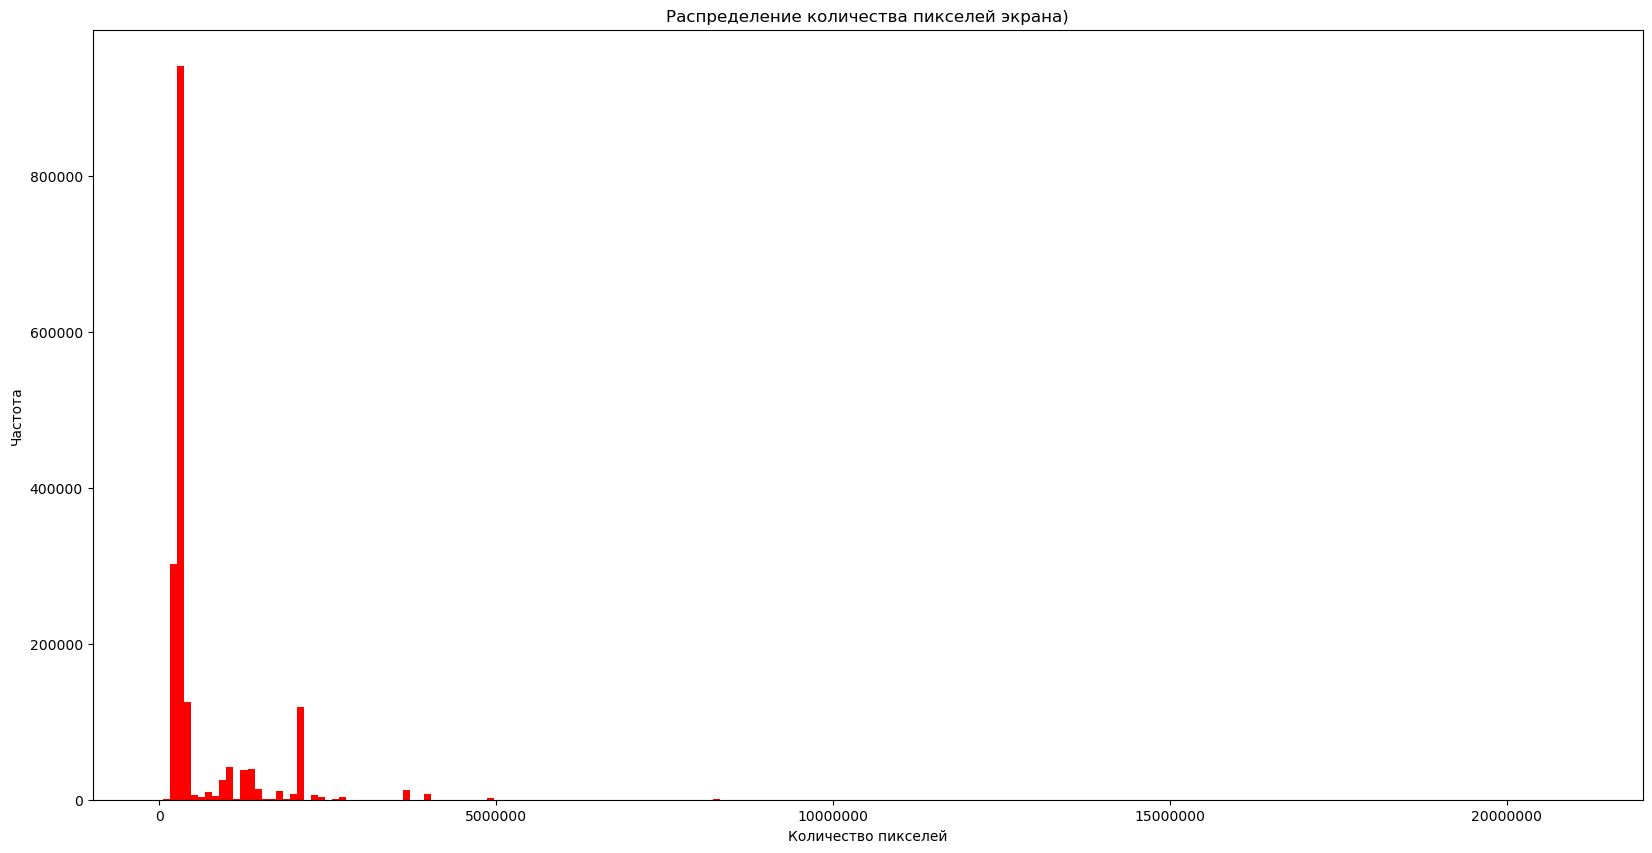

In [103]:
# Распределение количества пикселей экрана по частотам.
fig, ax = plt.subplots(figsize=(20, 10))

ax.hist(df.screen_area, bins=200, color='r')
ax.set_xlabel('Количество пикселей')
ax.set_ylabel('Частота')
ax.set_title('Распределение количества пикселей экрана)')

ax.xaxis.set_major_formatter(FormatStrFormatter('%.0f'));

In [104]:
# Убедимся, что самые большие значения не являются выбросами, а имеют место быть.
df[(df['screen_area'] > 15_000_000)]

,visit_number,device_category,device_os,device_screen_resolution,geo_country,geo_city,target,utm_source_upd,utm_medium_upd,utm_campaign_upd,utm_adcontent_upd,device_brand_upd,device_browser_upd,month,day_of_month,day_of_week,hour_of_day,screen_width,screen_height,screen_area
80831,1,desktop,Linux,4096x5120,Russia,Mytishchi,0,RmEBuqrriAfAVsLQQmhk,cpc,bgTYkDHjOsJzMUtoGhiQ,JNHcPlZPxEMWDnRiyoBf,unknown,Chrome,9,22,2,22,4096,5120,20971520
433140,1,desktop,Android,4096x5120,Russia,Mytishchi,0,RmEBuqrriAfAVsLQQmhk,cpc,aLJBnHfwxXTnAjVTpHFh,JNHcPlZPxEMWDnRiyoBf,unknown,Chrome,9,24,4,7,4096,5120,20971520
504331,1,desktop,Linux,4096x5120,Russia,Moscow,0,kjsLglQLzykiRbcDiGcD,cpc,UKNBOHebRIIsQRsjNKay,rare,unknown,Chrome,11,2,1,9,4096,5120,20971520
711357,1,desktop,Android,4096x5120,Russia,Mytishchi,0,geDcueAOghDzHkGMmdOq,cpm,FTjNLDyTrXaWYgZymFkV,WYLajZgbUhGimwBKDZUH,unknown,Chrome,7,10,5,19,4096,5120,20971520
731595,1,desktop,Android,4096x5120,Russia,Mytishchi,0,RmEBuqrriAfAVsLQQmhk,cpc,bgTYkDHjOsJzMUtoGhiQ,JNHcPlZPxEMWDnRiyoBf,unknown,Chrome,9,23,3,15,4096,5120,20971520
929253,1,desktop,Linux,4096x5120,Russia,Mytishchi,0,RmEBuqrriAfAVsLQQmhk,cpc,iYBYglGljMDRQyqHRiPH,JNHcPlZPxEMWDnRiyoBf,unknown,Chrome,9,22,2,13,4096,5120,20971520
1153664,1,desktop,Linux,4096x5120,Russia,Mytishchi,0,RmEBuqrriAfAVsLQQmhk,cpc,iYBYglGljMDRQyqHRiPH,JNHcPlZPxEMWDnRiyoBf,unknown,Chrome,9,23,3,13,4096,5120,20971520
1241847,1,desktop,Android,4096x5120,Russia,Mytishchi,0,RmEBuqrriAfAVsLQQmhk,cpc,aLJBnHfwxXTnAjVTpHFh,JNHcPlZPxEMWDnRiyoBf,unknown,Chrome,9,24,4,5,4096,5120,20971520
1350248,1,desktop,Linux,4096x5120,Russia,Moscow,0,fgymSoTvjKPEgaIJqsiH,cpm,FTjNLDyTrXaWYgZymFkV,yYdBRbPmBMUZHXwqGxNx,unknown,Chrome,12,30,3,0,4096,5120,20971520
1500184,1,desktop,Android,4096x5120,Russia,Mytishchi,0,kjsLglQLzykiRbcDiGcD,cpc,rare,vilbbyUvEWbiJvxXpaNN,unknown,Chrome,9,8,2,7,4096,5120,20971520


In [105]:
# Зная, как менялось разрешение экрана устройств с прогрессом технологий, можно сгенерировать признак 'device_age' (возраст устройства).
df['device_age'] =  df.apply(lambda x: "new_top" if x.screen_area > 2000000 
                                  else ("new" if 800000 < x.screen_area <= 2000000 
                                        else ("average" if 300000 < x.screen_area <= 800000 else "old" )), axis=1)
df['device_age']

0              old
1          average
2              old
3          average
4          average
            ...   
1732261    new_top
1732262    average
1732263        old
1732264    average
1732265        new
Name: device_age, Length: 1732229, dtype: object

In [106]:
# Подсчет количества значений признака 'device_age'.
df['device_age'].value_counts()

average    837436
old        550961
new        178896
new_top    164936
Name: device_age, dtype: int64

In [107]:
# Удалим колонки, которые использовали для генерации новых признаков.
df = df.drop(columns=['screen_area','device_screen_resolution'])
df.head()

,visit_number,device_category,device_os,geo_country,geo_city,target,utm_source_upd,utm_medium_upd,utm_campaign_upd,utm_adcontent_upd,device_brand_upd,device_browser_upd,month,day_of_month,day_of_week,hour_of_day,screen_width,screen_height,device_age
0,1,mobile,Android,Russia,Zlatoust,0,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,Huawei,Chrome,11,24,2,14,360,720,old
1,1,mobile,Android,Russia,Moscow,0,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,Samsung,Samsung Internet,11,14,6,8,385,854,average
2,1,mobile,Android,Russia,Krasnoyarsk,0,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,Huawei,Chrome,12,28,1,2,360,720,old
3,1,mobile,Android,Russia,Moscow,0,kjsLglQLzykiRbcDiGcD,cpc,other,NOBKLgtuvqYWkXQHeYWM,Xiaomi,Chrome,5,29,5,5,393,786,average
4,2,mobile,Android,Russia,Moscow,0,kjsLglQLzykiRbcDiGcD,cpc,other,other,Xiaomi,Chrome,5,29,5,5,393,786,average


##### На основе 'utm_source_upd'

In [108]:
lst = ['QxAxdyPLuQMEcrdZWdWb', 'MvfHsxITijuriZxsqZqt', 'ISrKoXQCxqqYvAZICvjs', 'IZEXUFLARCUMynmHNBGo', 'PlbkrSYoHuZBWfYjYnfw', 
       'gVRrcxiDQubJiljoTbGm']

# Создание новой колонки 'social_net_adv' (реклама в социальных сетях) с присвоением категориям из lst значения '1'.
df['social_net_adv'] = df.apply(lambda x: 1 if x.utm_source_upd in lst else 0, axis=1)
df.head()

,visit_number,device_category,device_os,geo_country,geo_city,target,utm_source_upd,utm_medium_upd,utm_campaign_upd,utm_adcontent_upd,device_brand_upd,device_browser_upd,month,day_of_month,day_of_week,hour_of_day,screen_width,screen_height,device_age,social_net_adv
0,1,mobile,Android,Russia,Zlatoust,0,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,Huawei,Chrome,11,24,2,14,360,720,old,0
1,1,mobile,Android,Russia,Moscow,0,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,Samsung,Samsung Internet,11,14,6,8,385,854,average,1
2,1,mobile,Android,Russia,Krasnoyarsk,0,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,Huawei,Chrome,12,28,1,2,360,720,old,0
3,1,mobile,Android,Russia,Moscow,0,kjsLglQLzykiRbcDiGcD,cpc,other,NOBKLgtuvqYWkXQHeYWM,Xiaomi,Chrome,5,29,5,5,393,786,average,0
4,2,mobile,Android,Russia,Moscow,0,kjsLglQLzykiRbcDiGcD,cpc,other,other,Xiaomi,Chrome,5,29,5,5,393,786,average,0


##### На основе 'utm_medium_upd'

In [109]:
lst = ['organic', 'referral', '(none)']

# Создание новой колонки 'organic_traffic' (органический траффик) с присвоением категориям из lst значения '1'.
df['organic_traffic'] = df.apply(lambda x: 1 if x.utm_medium_upd in lst else 0, axis=1)
df.head()

,visit_number,device_category,device_os,geo_country,geo_city,target,utm_source_upd,utm_medium_upd,utm_campaign_upd,utm_adcontent_upd,...,device_browser_upd,month,day_of_month,day_of_week,hour_of_day,screen_width,screen_height,device_age,social_net_adv,organic_traffic
0,1,mobile,Android,Russia,Zlatoust,0,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,...,Chrome,11,24,2,14,360,720,old,0,0
1,1,mobile,Android,Russia,Moscow,0,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,...,Samsung Internet,11,14,6,8,385,854,average,1,0
2,1,mobile,Android,Russia,Krasnoyarsk,0,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,...,Chrome,12,28,1,2,360,720,old,0,0
3,1,mobile,Android,Russia,Moscow,0,kjsLglQLzykiRbcDiGcD,cpc,other,NOBKLgtuvqYWkXQHeYWM,...,Chrome,5,29,5,5,393,786,average,0,0
4,2,mobile,Android,Russia,Moscow,0,kjsLglQLzykiRbcDiGcD,cpc,other,other,...,Chrome,5,29,5,5,393,786,average,0,0


##### На основе 'geo_country'

In [110]:
# Вывод количества значений.
df.geo_country.value_counts()

Russia                 1682414
Ukraine                   8455
United States             8141
Belarus                   3432
Kazakhstan                2109
                        ...   
New Caledonia                1
Congo - Brazzaville          1
Rwanda                       1
Barbados                     1
Burundi                      1
Name: geo_country, Length: 159, dtype: int64

In [111]:
# Просмотр уникальных значений.
df.geo_country.unique()

array(['Russia', 'United States', 'Ukraine', 'Italy', 'Belarus',
       '(not set)', 'Sweden', 'Australia', 'Kazakhstan', 'Estonia',
       'Azerbaijan', 'Brazil', 'Montenegro', 'Bulgaria', 'Georgia',
       'Uzbekistan', 'Tajikistan', 'Ireland', 'Cyprus',
       'United Arab Emirates', 'Germany', 'United Kingdom', 'Netherlands',
       'Spain', 'Finland', 'Turkey', 'Poland', 'Kyrgyzstan', 'India',
       'Bangladesh', 'Latvia', 'Seychelles', 'Norway', 'Armenia',
       'Argentina', 'Guatemala', 'Lithuania', 'Iraq', 'Canada', 'Greece',
       'Antigua & Barbuda', 'France', 'Slovakia', 'Palestine',
       'Saudi Arabia', 'Iran', 'Czechia', 'Austria', 'Singapore',
       'Moldova', 'Indonesia', 'Dominican Republic', 'Denmark', 'Albania',
       'Switzerland', 'China', 'Portugal', 'Israel', 'Slovenia',
       'Iceland', 'Maldives', 'Mexico', 'Wallis & Futuna', 'Egypt',
       'Guadeloupe', 'South Korea', 'Hungary', 'Uganda',
       'Bosnia & Herzegovina', 'Thailand', 'Romania', 'Turkmenis

In [112]:
lst = ['Ukraine', 'Belarus', 'Kazakhstan', 'Estonia', 'Azerbaijan', 'Georgia', 'Uzbekistan', 'Tajikistan', 'Kyrgyzstan', 
       'Latvia', 'Armenia', 'Lithuania', 'Moldova', 'Turkmenistan']

# Создание новой колонки 'is_post_soviet' (постсоветские страны) с присвоением категориям из lst значения '1'.
df['is_post_soviet'] = df.apply(lambda x: 1 if x.geo_country in lst else 0, axis=1)
df.head()

,visit_number,device_category,device_os,geo_country,geo_city,target,utm_source_upd,utm_medium_upd,utm_campaign_upd,utm_adcontent_upd,...,month,day_of_month,day_of_week,hour_of_day,screen_width,screen_height,device_age,social_net_adv,organic_traffic,is_post_soviet
0,1,mobile,Android,Russia,Zlatoust,0,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,...,11,24,2,14,360,720,old,0,0,0
1,1,mobile,Android,Russia,Moscow,0,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,...,11,14,6,8,385,854,average,1,0,0
2,1,mobile,Android,Russia,Krasnoyarsk,0,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,...,12,28,1,2,360,720,old,0,0,0
3,1,mobile,Android,Russia,Moscow,0,kjsLglQLzykiRbcDiGcD,cpc,other,NOBKLgtuvqYWkXQHeYWM,...,5,29,5,5,393,786,average,0,0,0
4,2,mobile,Android,Russia,Moscow,0,kjsLglQLzykiRbcDiGcD,cpc,other,other,...,5,29,5,5,393,786,average,0,0,0


In [113]:
lst = ['Italy', 'Sweden', 'Montenegro', 'Bulgaria', 'Ireland', 'Germany', 'United Kingdom', 'Netherlands', 'Spain', 'Finland',
       'Poland', 'Norway', 'Greece', 'France', 'Slovakia', 'Czechia', 'Austria', 'Denmark', 'Albania', 'Switzerland', 'Portugal',
       'Slovenia', 'Iceland', 'Hungary', 'Bosnia & Herzegovina', 'Romania', 'Croatia', 'Malta', 'Serbia', 'Luxembourg',
       'Belgium', 'North Macedonia', 'Andorra', 'Monaco', 'Gibraltar', 'Faroe Islands', 'Guernsey']

# Создание новой колонки 'is_europe' (европейские страны) с присвоением категориям из lst значения '1'.
df['is_europe'] = df.apply(lambda x: 1 if x.geo_country in lst else 0, axis=1)
df.head()

,visit_number,device_category,device_os,geo_country,geo_city,target,utm_source_upd,utm_medium_upd,utm_campaign_upd,utm_adcontent_upd,...,day_of_month,day_of_week,hour_of_day,screen_width,screen_height,device_age,social_net_adv,organic_traffic,is_post_soviet,is_europe
0,1,mobile,Android,Russia,Zlatoust,0,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,...,24,2,14,360,720,old,0,0,0,0
1,1,mobile,Android,Russia,Moscow,0,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,...,14,6,8,385,854,average,1,0,0,0
2,1,mobile,Android,Russia,Krasnoyarsk,0,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,...,28,1,2,360,720,old,0,0,0,0
3,1,mobile,Android,Russia,Moscow,0,kjsLglQLzykiRbcDiGcD,cpc,other,NOBKLgtuvqYWkXQHeYWM,...,29,5,5,393,786,average,0,0,0,0
4,2,mobile,Android,Russia,Moscow,0,kjsLglQLzykiRbcDiGcD,cpc,other,other,...,29,5,5,393,786,average,0,0,0,0


In [114]:
lst = ['Cyprus', 'United Arab Emirates', 'Turkey', 'Iraq', 'Saudi Arabia', 'Iran', 'Israel', 'Egypt', 'Lebanon', 'Qatar',
       'Kuwait', 'Syria', 'Oman', 'Jordan', 'Yemen']

# Создание новой колонки 'is_near_east' (ближневосточные страны) с присвоением категориям из lst значения '1'.
df['is_near_east'] = df.apply(lambda x: 1 if x.geo_country in lst else 0, axis=1)
df.head()

,visit_number,device_category,device_os,geo_country,geo_city,target,utm_source_upd,utm_medium_upd,utm_campaign_upd,utm_adcontent_upd,...,day_of_week,hour_of_day,screen_width,screen_height,device_age,social_net_adv,organic_traffic,is_post_soviet,is_europe,is_near_east
0,1,mobile,Android,Russia,Zlatoust,0,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,...,2,14,360,720,old,0,0,0,0,0
1,1,mobile,Android,Russia,Moscow,0,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,...,6,8,385,854,average,1,0,0,0,0
2,1,mobile,Android,Russia,Krasnoyarsk,0,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,...,1,2,360,720,old,0,0,0,0,0
3,1,mobile,Android,Russia,Moscow,0,kjsLglQLzykiRbcDiGcD,cpc,other,NOBKLgtuvqYWkXQHeYWM,...,5,5,393,786,average,0,0,0,0,0
4,2,mobile,Android,Russia,Moscow,0,kjsLglQLzykiRbcDiGcD,cpc,other,other,...,5,5,393,786,average,0,0,0,0,0


##### На основе 'geo_city'

In [115]:
# Количество строк, в которых 'geo_country' неизвестно.
# И количество строк, в которых неизвестно 'geo_country' и 'geo_city' одновременно.
print(len(df[(df['geo_country'] == '(not set)')]))
print(len(df[(df['geo_country'] == '(not set)') & (df['geo_city'] == '(not set)')]))
# Видим: во всех случаях, где неизвестно 'geo_country', там же неизвестно и 'geo_city'. 

1043
1043


In [116]:
df.shape

(1732229, 24)

In [117]:
# Удалим строки со значениями '(no set)' в колонках 'geo_country' и 'geo_city'.
df = df[(df['geo_country'] != '(not set)')]
df.shape

(1731186, 24)

In [118]:
# Создадим колонку 'geo_city_upd', в которую положим самые часто встречающиеся названия городов для каждой из стран.
df['geo_city_upd'] = df.groupby('geo_country')['geo_city'].transform(lambda x: x.mode()[0])
df.geo_city_upd.unique()

array(['Moscow', 'Prineville', 'Kyiv', 'Milan', 'Minsk', 'Lulea',
       'Sydney', 'Almaty', 'Tallinn', 'Baku', '53425', 'Podgorica',
       '(not set)', 'Tashkent', 'Dushanbe', 'Dublin', 'Dubai',
       'Frankfurt', 'London', 'Amsterdam', 'Helsinki', 'Warsaw',
       'Bishkek', 'Gurgaon', 'Riga', 'Oslo Municipality', 'Yerevan',
       'Buenos Aires', 'Vilnius', 'Toronto', 'Paris', 'Bratislava',
       'Riyadh', 'Tehran', 'Prague', 'Vienna', 'Singapore', 'Chisinau',
       'Jakarta', 'Ballerup', 'Tirana', 'Zurich', 'Shanghai', 'Lisbon',
       'Tel Aviv-Yafo', 'Ljubljana', 'Mexico City', 'Cairo', 'Seoul',
       'Budapest', 'Kampala', 'Sarajevo', 'Bangkok', 'Bucharest',
       'Ashgabat', 'Beirut', 'Zagreb', 'Havana', 'Khartoum', 'Phnom Penh',
       'Islamabad', 'Kabul', 'Ho Chi Minh City', 'Ulaanbaatar',
       'Port Louis', 'Bangui', 'Bujumbura', 'Doha', 'Belgrade',
       'Casablanca', 'Luxembourg', 'Brussels', 'Lome', 'Caracas',
       'Colombo', 'Sandton', 'Luanda', 'Conakry', 'N

In [119]:
# Изменим значения '(not set)' в 'geo_city' на название самого часто встречающегося названия города этой страны.
df.loc[(df.geo_city=='(not set)'), 'geo_city'] = df['geo_city_upd']

In [120]:
# Видим, что строки с неизвестными значениями в 'geo_city' еще есть.
df[(df.geo_city=='(not set)')]

,visit_number,device_category,device_os,geo_country,geo_city,target,utm_source_upd,utm_medium_upd,utm_campaign_upd,utm_adcontent_upd,...,hour_of_day,screen_width,screen_height,device_age,social_net_adv,organic_traffic,is_post_soviet,is_europe,is_near_east,geo_city_upd
1120,1,mobile,iOS,Georgia,(not set),0,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,...,7,390,844,average,0,1,1,0,0,(not set)
1121,2,mobile,iOS,Georgia,(not set),0,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,...,8,390,844,average,0,1,1,0,0,(not set)
1161,1,mobile,Android,Georgia,(not set),0,ZpYIoDJMcFzVoPFsHGJL,banner,TmThBvoCcwkCZZUWACYq,JNHcPlZPxEMWDnRiyoBf,...,22,393,873,average,0,0,1,0,0,(not set)
2409,4,mobile,iOS,Spain,(not set),0,jaSOmLICuBzCFqHfBdRg,email,bxOTvPtyGSdUrbwoXCPO,JNHcPlZPxEMWDnRiyoBf,...,16,414,896,average,0,0,0,1,0,(not set)
2472,1,mobile,iOS,Turkey,(not set),0,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,...,12,375,812,average,0,1,0,0,1,(not set)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1731085,3,mobile,Android,Svalbard & Jan Mayen,(not set),0,ZpYIoDJMcFzVoPFsHGJL,smartbanner,jqlUOdZBNZYfInQVcZlS,qhEmhjPXvwgEHdBikgEQ,...,0,393,873,average,0,0,0,0,0,(not set)
1731527,1,desktop,Android,Wallis & Futuna,(not set),0,PlbkrSYoHuZBWfYjYnfw,cpm,FTjNLDyTrXaWYgZymFkV,TuyPWsGQruPMpKvRxeBF,...,18,2560,1440,new_top,1,0,0,0,0,(not set)
1731761,1,desktop,iOS,Tunisia,(not set),0,kjsLglQLzykiRbcDiGcD,cpc,bJJuEXRheRIxXEaYIXqM,JNHcPlZPxEMWDnRiyoBf,...,18,1440,900,new,0,0,0,0,0,(not set)
1731762,2,desktop,iOS,Tunisia,(not set),0,kjsLglQLzykiRbcDiGcD,cpc,other,other,...,18,1440,900,new,0,0,0,0,0,(not set)


In [121]:
# Заменим их на название страны.
df.loc[(df.geo_city=='(not set)'), 'geo_city'] = df['geo_country']

In [122]:
# Убедимся, что значений '(not set)' не осталось.
print(len(df[(df.geo_city=='(not set)')]))

0


In [123]:
# Количество уникальных значений 'geo_city'.
df.geo_city.nunique()

2428

In [124]:
# Список из уникальных значений.
lst = list(df.geo_city.unique())
lst

['Zlatoust',
 'Moscow',
 'Krasnoyarsk',
 'Saint Petersburg',
 'Sochi',
 'Yaroslavl',
 'Mytishchi',
 'Novorossiysk',
 'Balashikha',
 'Pushkino',
 'Vladivostok',
 'Alexandrov',
 'Astrakhan',
 'Sunny Isles Beach',
 'Reutov',
 'Kazan',
 'Ulyanovsk',
 'Tula',
 'Yekaterinburg',
 'Rostov-on-Don',
 'Samara',
 'Domodedovo',
 'Yoshkar-Ola',
 'Chelyabinsk',
 'Krasnogorsk',
 'Krasnodar',
 'Lipetsk',
 'Nakhabino',
 'Kyzyl',
 'Ryazan',
 'Tyumen',
 'Omsk',
 'Nizhny Novgorod',
 'Mezhdurechensk',
 'Tuymazy',
 'Stupino',
 'Serpukhov',
 'Saratov',
 'Grozny',
 'Orenburg',
 'Surgut',
 'Kyiv',
 'Volgograd',
 'Engels',
 'Fryazino',
 'Naberezhnye Chelny',
 'Khabarovsk',
 'Ufa',
 'Novosibirsk',
 'Kirov',
 'Kotelniki',
 'Prineville',
 'Kaluga',
 'Vyborg',
 'Barnaul',
 'Lecce',
 'Tambov',
 'Minsk',
 'Tver',
 'Yalta',
 'Fort Worth',
 'Kostroma',
 'Zheleznodorozhny',
 'Kursk',
 'Pyatigorsk',
 'Ashburn',
 'Izhevsk',
 'Chita',
 'Cherkessk',
 'Blagoveshchensk',
 'Lulea',
 'Voronezh',
 'Nalchik',
 'Obninsk',
 'Belgoro

Ниже описан алгоритм, по которому с помощью библиотеки geopy создан новый признак на основе названия города. Сделано это "удаленно", так как используемый api-сервис требует подключения к интернету, может быть не всегда доступен, и на это может уйти много времени.

1. Создаем вспомогательный датафрейм из одного столбца, в котором содержаться уникальные значения названий городов (и в редких случаях - назнаний стран, если назвение города неизвестно)                                                                  

df_geo = pd.DataFrame(lst, columns=['geo_city'])

2. Импортируем из предварительно установленной библиотеки "geopy" api-сервис "Nominatim"

from geopy.geocoders import Nominatim

3. Создание объекта класса "Nominatim" с подходящими параметрами

geolocator = Nominatim(user_agent="myApp", timeout=5)

4. Используя метод "geocode", создадим колонку "geo_info" в которую загрузится подробная географическая информация для каждого города из "geo_city"

df_geo['geo_info'] = df_geo['geo_city'].apply(geolocator.geocode)

5. К созданной колонке "geo_info" с объектом нового класса "Nominatim" применим методы "latitude" и "longitude" для извлечения долготы и широты. Полученную информацию положим в новые соответствующие колонки.

df_geo['city_lat'] = df_geo['geo_info'].apply(lambda x: x.latitude if x != None else None)

df_geo['city_long'] = df_geo['geo_info'].apply(lambda x: x.longitude if x != None else None)

6. Сохраним созданный вспомогательный датафрейм в csv-файл для использования в дальнейшей работе.

df_geo.to_csv('data/city_lat_long.csv', index=False)

In [125]:
# Загрузим созданный вспомогательный датафрейм.
df_geo = pd.read_csv('data/city_lat_long.csv')
df_geo.head()

,geo_city,geo_info,city_lat,city_long
0,Zlatoust,"Златоуст, Златоустовский городской округ, Челя...",55.167421,59.679263
1,Moscow,"Москва, Центральный федеральный округ, Россия",55.750446,37.617494
2,Krasnoyarsk,"Красноярский край, Сибирский федеральный округ...",63.323381,97.097997
3,Saint Petersburg,"Saint Petersburg, Pinellas County, Florida, Un...",27.770380,-82.669508
4,Sochi,"Сочи, городской округ Сочи, Краснодарский край...",43.585482,39.723109


In [126]:
# Можно заметить, что он содержит пропуски.
df_geo[df_geo.geo_info.isna()]

,geo_city,geo_info,city_lat,city_long
34,Tuymazy,NaN,NaN,NaN
161,Petrovo-Dalneye,NaN,NaN,NaN
175,Yablonovsky,NaN,NaN,NaN
210,Oktyabrs'ke,NaN,NaN,NaN
233,Zagorjanskas,NaN,NaN,NaN
...,...,...,...,...
2136,Sandnes Municipality,NaN,NaN,NaN
2256,Pervomais'kyi,NaN,NaN,NaN
2345,Vovchans'k,NaN,NaN,NaN
2347,Kresttsy,NaN,NaN,NaN


In [127]:
# Это объястняется тем, что названий населенных пунктов из списка ниже api-сервис не нашел информации.
# Вероятно, эти названия имеют неверный синтаксис.
df_geo[df_geo.geo_info.isna()].geo_city.unique()

array(['Tuymazy', 'Petrovo-Dalneye', 'Yablonovsky', "Oktyabrs'ke",
       'Zagorjanskas', 'Belebey', "Armyans'k", "Khartsyz'k",
       'Novoye Devyatkino', 'Krasnoturyinsk', 'Zhigulevsk', 'Kalininets',
       'Chusovskoye Urban Settlement', 'Ruzayevka', "Shakhtars'k",
       "Debal'tseve", "Velykodolyns'ke", "Pervomais'k",
       'Troedobelikovskiy', "Chornomors'ke", 'Kolomyya', "Roven'ky",
       "Hresivs'kyi", 'Dzhankoi', "Berdyans'k", 'Arsenyev', "Alchevs'k",
       'Dobropillya', 'Veliky Ustyug', 'Yenakijeve', 'Dorokhovskoja',
       "Bilohirs'k", 'Novomikhailovskii', "Emel'yanovo", "Ilovais'k",
       'Voronezjskaja', 'Wolno-Nadeschdinskoje', 'Zavolzhye',
       'Chystiakove', "Krasnohvardiis'ke", "Dolyns'ka", "Sovjets'kyi",
       "Novoazovs'k", 'Lorenskog Municipality', 'Artemovskiy',
       "Dokuchajevs'k", "Mohyliv-Podil's'kyi", "Starobil's'k",
       "Yuzhnoukrains'k", 'Kobelyaky', "Krasnoperekops'k",
       'Stolberg (Rhineland)', "Bilhorod-Dnistrovs'kyi",
       'Fredriksta

In [128]:
df_geo.shape

(2428, 4)

In [129]:
# Объединим основной и вспомогательный датафреймы по колонке 'geo_city'.
df = pd.merge(left=df, right=df_geo, on='geo_city')
df.head()

,visit_number,device_category,device_os,geo_country,geo_city,target,utm_source_upd,utm_medium_upd,utm_campaign_upd,utm_adcontent_upd,...,device_age,social_net_adv,organic_traffic,is_post_soviet,is_europe,is_near_east,geo_city_upd,geo_info,city_lat,city_long
0,1,mobile,Android,Russia,Zlatoust,0,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,...,old,0,0,0,0,0,Moscow,"Златоуст, Златоустовский городской округ, Челя...",55.167421,59.679263
1,1,desktop,Windows,Russia,Zlatoust,0,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,...,new,0,1,0,0,0,Moscow,"Златоуст, Златоустовский городской округ, Челя...",55.167421,59.679263
2,1,mobile,Android,Russia,Zlatoust,0,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,...,old,0,0,0,0,0,Moscow,"Златоуст, Златоустовский городской округ, Челя...",55.167421,59.679263
3,2,mobile,Android,Russia,Zlatoust,0,YlsczTIyBSwTLNtuDkCd,outlook,PTQlxxEuqjyfVHcNKQQW,JNHcPlZPxEMWDnRiyoBf,...,average,0,0,0,0,0,Moscow,"Златоуст, Златоустовский городской округ, Челя...",55.167421,59.679263
4,1,mobile,Android,Russia,Zlatoust,0,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,JNHcPlZPxEMWDnRiyoBf,...,average,0,0,0,0,0,Moscow,"Златоуст, Златоустовский городской округ, Челя...",55.167421,59.679263


In [130]:
# Количество пропусков.
df.isna().sum().sort_values(ascending=False)

city_long             2960
geo_info              2960
city_lat              2960
month                    0
device_category          0
device_os                0
geo_country              0
geo_city                 0
target                   0
utm_source_upd           0
utm_medium_upd           0
utm_campaign_upd         0
utm_adcontent_upd        0
device_brand_upd         0
device_browser_upd       0
day_of_month             0
day_of_week              0
hour_of_day              0
screen_width             0
screen_height            0
device_age               0
social_net_adv           0
organic_traffic          0
is_post_soviet           0
is_europe                0
is_near_east             0
geo_city_upd             0
visit_number             0
dtype: int64

In [131]:
# Удаление строк, содержащих пропуски, с сохранением правильной последовательности в индексе.
df = df.dropna().reset_index(drop=True)
df.shape

(1728226, 28)

In [132]:
# Просмотр количества значений целевой переменной.
df.target.value_counts()

0    1678018
1      50208
Name: target, dtype: int64

In [133]:
# Удаление колонок, задействованных при создании признаков на основе 'geo_city'.
# И вывод списка колонок финального датасета.
df = df.drop(columns=['geo_city', 'geo_city_upd', 'geo_info'])
df.columns

Index(['visit_number', 'device_category', 'device_os', 'geo_country', 'target',
       'utm_source_upd', 'utm_medium_upd', 'utm_campaign_upd',
       'utm_adcontent_upd', 'device_brand_upd', 'device_browser_upd', 'month',
       'day_of_month', 'day_of_week', 'hour_of_day', 'screen_width',
       'screen_height', 'device_age', 'social_net_adv', 'organic_traffic',
       'is_post_soviet', 'is_europe', 'is_near_east', 'city_lat', 'city_long'],
      dtype='object')

In [134]:
# Размерность финального датасета.
df.shape

(1728226, 25)

# Визуализация и закономерности

In [135]:
# Корреляционная матрица.
df.corr()

,visit_number,target,month,day_of_month,day_of_week,hour_of_day,screen_width,screen_height,social_net_adv,organic_traffic,is_post_soviet,is_europe,is_near_east,city_lat,city_long
visit_number,1.000000,0.027943,0.012195,-0.010844,-0.016625,0.004735,0.122564,0.048180,-0.044769,0.071526,-0.008842,-0.004241,-0.002530,0.023715,0.012216
target,0.027943,1.000000,-0.051373,-0.000812,-0.014535,0.000105,0.006710,0.010356,-0.033156,0.055646,-0.001901,-0.001503,-0.000129,0.007810,0.007643
month,0.012195,-0.051373,1.000000,-0.160048,0.092207,0.024611,-0.118834,-0.066702,0.094170,-0.320337,-0.009637,-0.011379,-0.004124,-0.010720,0.036843
day_of_month,-0.010844,-0.000812,-0.160048,1.000000,-0.054995,-0.005278,0.002133,-0.001243,-0.030935,0.062277,0.008091,-0.001191,0.000724,0.003934,0.002080
day_of_week,-0.016625,-0.014535,0.092207,-0.054995,1.000000,-0.023191,-0.074687,-0.056255,0.047801,-0.088320,-0.008071,-0.014271,0.001585,-0.008200,-0.000834
hour_of_day,0.004735,0.000105,0.024611,-0.005278,-0.023191,1.000000,-0.013711,0.000431,0.003197,0.017995,0.005510,0.000819,0.001407,-0.007876,-0.039912
screen_width,0.122564,0.006710,-0.118834,0.002133,-0.074687,-0.013711,1.000000,0.590210,0.011138,0.202292,0.001726,0.066007,-0.007696,0.052147,-0.009418
screen_height,0.048180,0.010356,-0.066702,-0.001243,-0.056255,0.000431,0.590210,1.000000,-0.108847,0.151845,0.004071,0.124349,0.004188,0.034473,-0.026060
social_net_adv,-0.044769,-0.033156,0.094170,-0.030935,0.047801,0.003197,0.011138,-0.108847,1.000000,-0.243981,-0.013193,0.011522,-0.009046,-0.053876,-0.118694
organic_traffic,0.071526,0.055646,-0.320337,0.062277,-0.088320,0.017995,0.202292,0.151845,-0.243981,1.000000,0.022476,0.042718,0.018937,0.029190,0.010214


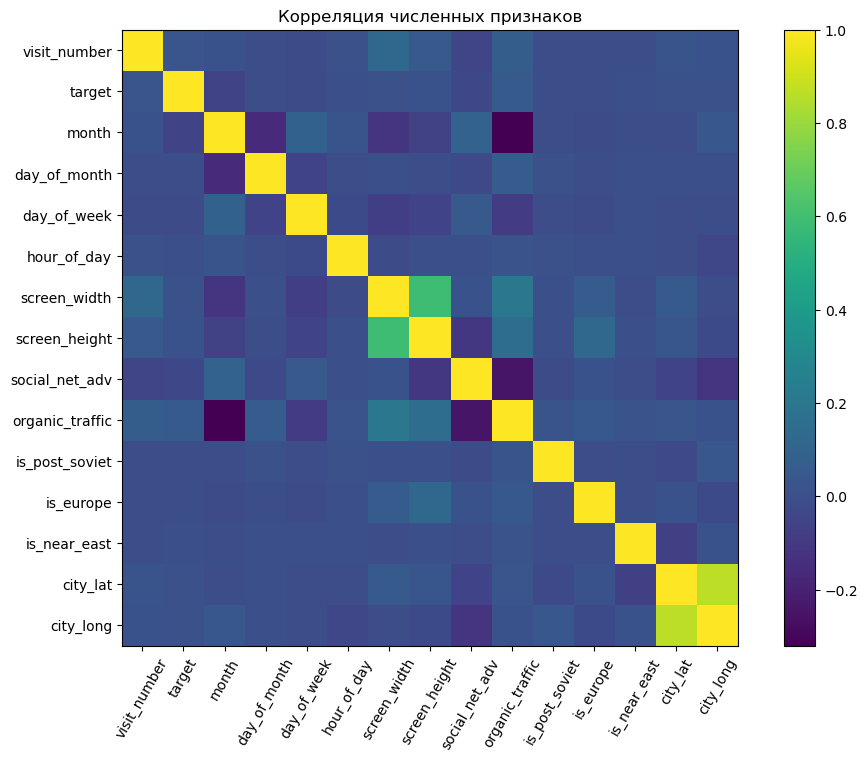

In [136]:
# Визуализированная корреляционная матрица.
# Видим, что целевая переменная ни с чем не коррелирует.
# Есть корреляция широты/долготы и ширины/высоты экрана, но для двухмерных пространственных признаков это допустимо.
plt.figure(figsize=(12, 8))

columns = df.corr().columns.tolist()
plt.imshow(df.corr())

plt.title("Корреляция численных признаков")
plt.xticks(range(0, len(columns)), columns, rotation=60)
plt.yticks(range(0, len(columns)), columns)
plt.colorbar()
plt.show()

In [137]:
# Показатель конверсии из визита в любое целевое действие в рамках одного визита всего датафрейма.
# Понадобиться нам в дальнейшем для анализа сгенерированных признаков и зависимостей.
round(((len(df[df['target'] == 1]) / len(df)) * 100), 2)

2.91

##### Зависимость от месяца

In [138]:
# Датафрейм с количеством визитов, сгруппированных по месяцу.
stats = df.groupby(['month'], as_index=False)[['target']].count()
stats = stats.rename(columns={'target':'target_all'})
stats

,month,target_all
0,5,104349
1,6,160191
2,7,174304
3,8,154624
4,9,243313
5,10,262779
6,11,263232
7,12,365434


In [139]:
# Создание колонки с количеством визитов по месяцам, сконвертированных в целевое действие.
stats['target=1'] = stats.month.apply(lambda x: len(df[(df['month'] == x) & (df['target'] == 1)]))

In [140]:
# Создание колонки с процентом конверсии по месяцам.
stats['target%'] = round(((stats['target=1'] / stats['target_all'])*100), 1)
stats

,month,target_all,target=1,target%
0,5,104349,6418,6.2
1,6,160191,6590,4.1
2,7,174304,4879,2.8
3,8,154624,5482,3.5
4,9,243313,6027,2.5
5,10,262779,7097,2.7
6,11,263232,6426,2.4
7,12,365434,7289,2.0


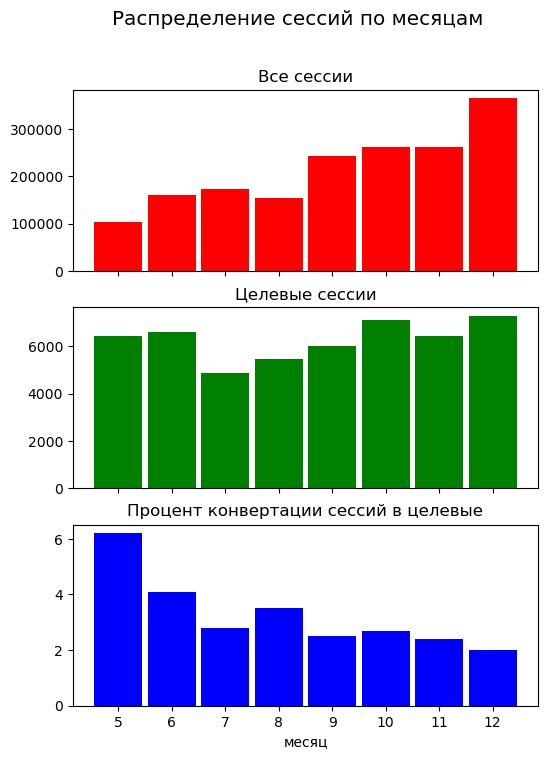

In [141]:
# Видим, что количество всех сессий росло, но процент конверсии падал с течением времени.
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, figsize=(6, 8), sharex=True)

ax1.bar(stats['month'], stats['target_all'], width=0.9, color='red')
ax1.set_title('Все сессии')

ax2.bar(stats['month'], stats['target=1'], width=0.9, color='green')
ax2.set_title('Целевые сессии')

ax3.bar(stats['month'], stats['target%'], width=0.9, color='blue')
ax3.set_xlabel('месяц')
ax3.set_title('Процент конвертации сессий в целевые')

fig.suptitle('Распределение сессий по месяцам', fontsize='x-large');

##### Зависимость от рекламного траффика и месяца

In [142]:
# Создание колонок с количеством сессий из рекламного траффика, целевых сессий из рекламного траффика и процента конверсии.
stats['social=1'] = stats.month.apply(lambda x: len(df[(df['month'] == x) & (df['social_net_adv'] == 1)]))
stats['social=1 & target=1'] = stats.month.apply(lambda x: len(df[(df['month'] == x) & (df['social_net_adv'] == 1) & (df['target'] == 1)]))
stats['social%'] = round(((stats['social=1 & target=1'] / stats['social=1'])*100), 1)
stats

,month,target_all,target=1,target%,social=1,social=1 & target=1,social%
0,5,104349,6418,6.2,16,1,6.2
1,6,160191,6590,4.1,17428,318,1.8
2,7,174304,4879,2.8,8156,69,0.8
3,8,154624,5482,3.5,29514,468,1.6
4,9,243313,6027,2.5,55723,688,1.2
5,10,262779,7097,2.7,47264,667,1.4
6,11,263232,6426,2.4,43276,786,1.8
7,12,365434,7289,2.0,54596,1021,1.9


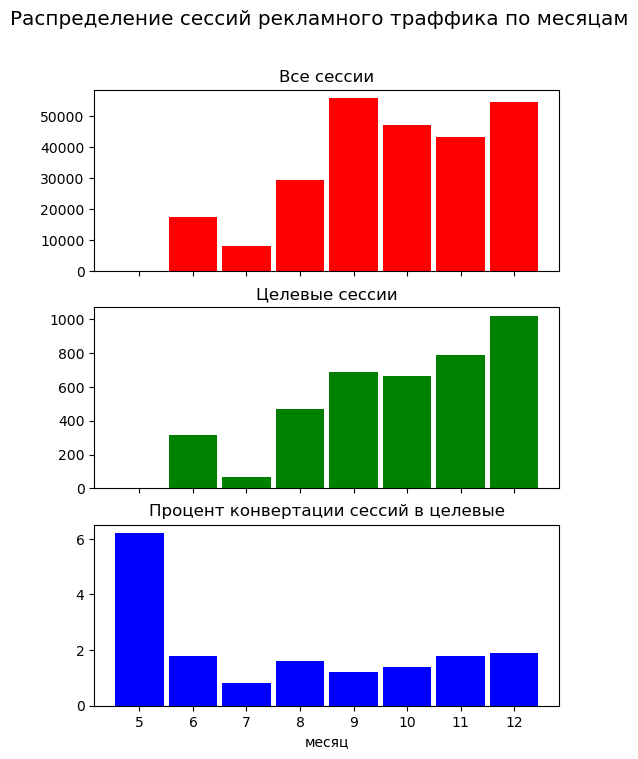

In [143]:
# За исключением первого наблюдаемого месяца, процент конверсии был значительно (на один пункт) ниже среднего по датафрейму.
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, figsize=(6, 8), sharex=True)

ax1.bar(stats['month'], stats['social=1'], width=0.9, color='red')
ax1.set_title('Все сессии')

ax2.bar(stats['month'], stats['social=1 & target=1'], width=0.9, color='green')
ax2.set_title('Целевые сессии')

ax3.bar(stats['month'], stats['social%'], width=0.9, color='blue')
ax3.set_xlabel('месяц')
ax3.set_title('Процент конвертации сессий в целевые')

fig.suptitle('Распределение сессий рекламного траффика по месяцам', fontsize='x-large');

##### Зависимость от органического траффика и месяца

In [144]:
# Создание колонок с количеством сессий из органического траффика, целевых сессий из органического траффика и процента конверсии.
stats['organic=1'] = stats.month.apply(lambda x: len(df[(df['month'] == x) & (df['organic_traffic'] == 1)]))
stats['organic=1 & target=1'] = stats.month.apply(lambda x: len(df[(df['month'] == x) & (df['organic_traffic'] == 1) & (df['target'] == 1)]))
stats['organic%'] = round(((stats['organic=1 & target=1'] / stats['organic=1'])*100), 1)
stats

,month,target_all,target=1,target%,social=1,social=1 & target=1,social%,organic=1,organic=1 & target=1,organic%
0,5,104349,6418,6.2,16,1,6.2,93782,6328,6.7
1,6,160191,6590,4.1,17428,318,1.8,63383,3739,5.9
2,7,174304,4879,2.8,8156,69,0.8,51694,2267,4.4
3,8,154624,5482,3.5,29514,468,1.6,48404,2265,4.7
4,9,243313,6027,2.5,55723,688,1.2,57441,1970,3.4
5,10,262779,7097,2.7,47264,667,1.4,48239,1772,3.7
6,11,263232,6426,2.4,43276,786,1.8,57434,1417,2.5
7,12,365434,7289,2.0,54596,1021,1.9,47251,1003,2.1


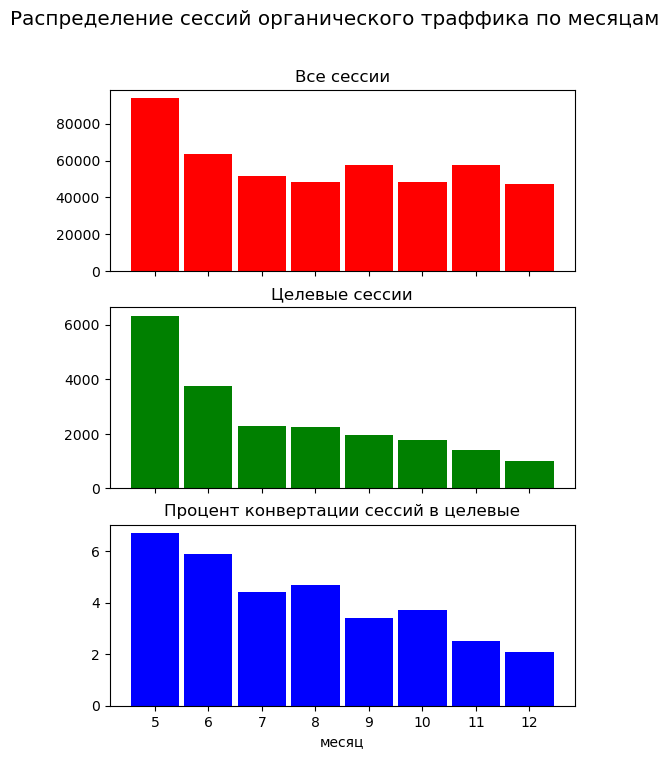

In [145]:
# Количество целевых сессий и процент конверсии органического траффика снижался с течением времени.
# Если в начале запуска сервиса конверсия была значительно выше средней, то в последние месяцы стала ниже.
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, figsize=(6, 8), sharex=True)

ax1.bar(stats['month'], stats['organic=1'], width=0.9, color='red')
ax1.set_title('Все сессии')

ax2.bar(stats['month'], stats['organic=1 & target=1'], width=0.9, color='green')
ax2.set_title('Целевые сессии')

ax3.bar(stats['month'], stats['organic%'], width=0.9, color='blue')
ax3.set_xlabel('месяц')
ax3.set_title('Процент конвертации сессий в целевые')

fig.suptitle('Распределение сессий органического траффика по месяцам', fontsize='x-large');

##### Зависимость от дня недели

In [146]:
# Датафрейм с количеством визитов, сгруппированных по дню недели.
stats2 = df.groupby(['day_of_week'], as_index=False)[['target']].count()
stats2 = stats2.rename(columns={'target':'target_all'})
stats2

,day_of_week,target_all
0,0,281138
1,1,286305
2,2,240375
3,3,251655
4,4,248015
5,5,210669
6,6,210069


In [147]:
# Создание колонок с количеством целевых визитов по дням недели и процента консерсии.
stats2['target=1'] = stats2.day_of_week.apply(lambda x: len(df[(df['day_of_week'] == x) & (df['target'] == 1)]))
stats2['target%'] = round(((stats2['target=1'] / stats2['target_all'])*100), 1)
stats2

,day_of_week,target_all,target=1,target%
0,0,281138,9450,3.4
1,1,286305,8665,3.0
2,2,240375,7265,3.0
3,3,251655,7218,2.9
4,4,248015,6539,2.6
5,5,210669,5557,2.6
6,6,210069,5514,2.6


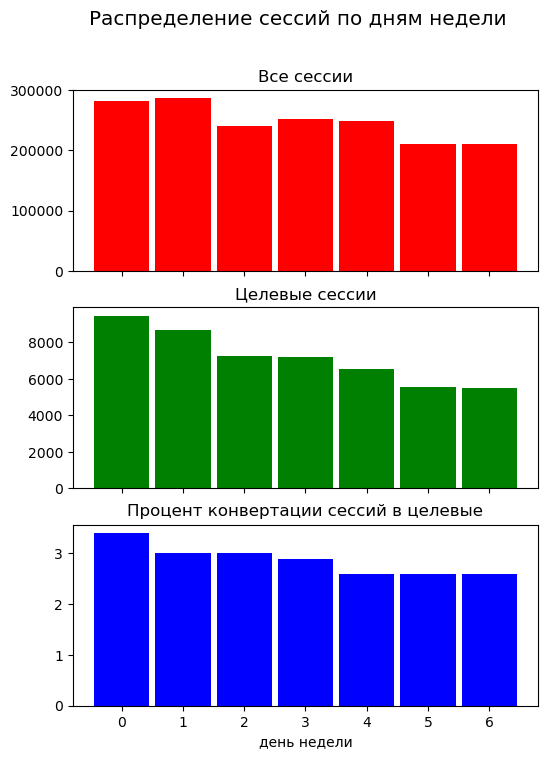

In [148]:
# Количество целевых сессий и процент конверсии выше в первой половине недели.
# Именно в эти дни обычно наблюдается максимальная продуктивность и осмысленность в действиях. 
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, figsize=(6, 8), sharex=True)

ax1.bar(stats2['day_of_week'], stats2['target_all'], width=0.9, color='red')
ax1.set_title('Все сессии')

ax2.bar(stats2['day_of_week'], stats2['target=1'], width=0.9, color='green')
ax2.set_title('Целевые сессии')

ax3.bar(stats2['day_of_week'], stats2['target%'], width=0.9, color='blue')
ax3.set_xlabel('день недели')
ax3.set_title('Процент конвертации сессий в целевые')

fig.suptitle('Распределение сессий по дням недели', fontsize='x-large');

##### Зависимость от дня месяца

In [149]:
# Датафрейм с количеством визитов, сгруппированных по дню месяца.
stats3 = df.groupby(['day_of_month'], as_index=False)[['target']].count()
stats3 = stats3.rename(columns={'target':'target_all'})
stats3

,day_of_month,target_all
0,1,48632
1,2,45821
2,3,44412
3,4,41093
4,5,47083
5,6,49410
6,7,47834
7,8,46585
8,9,47119
9,10,48980


In [150]:
# Создание колонок с количеством целевых визитов по дням месяца и процента консерсии.
stats3['target=1'] = stats3.day_of_month.apply(lambda x: len(df[(df['day_of_month'] == x) & (df['target'] == 1)]))
stats3['target%'] = round(((stats3['target=1'] / stats3['target_all'])*100), 1)
stats3

,day_of_month,target_all,target=1,target%
0,1,48632,1527,3.1
1,2,45821,1553,3.4
2,3,44412,1449,3.3
3,4,41093,1275,3.1
4,5,47083,1375,2.9
5,6,49410,1371,2.8
6,7,47834,1376,2.9
7,8,46585,1370,2.9
8,9,47119,1352,2.9
9,10,48980,1264,2.6


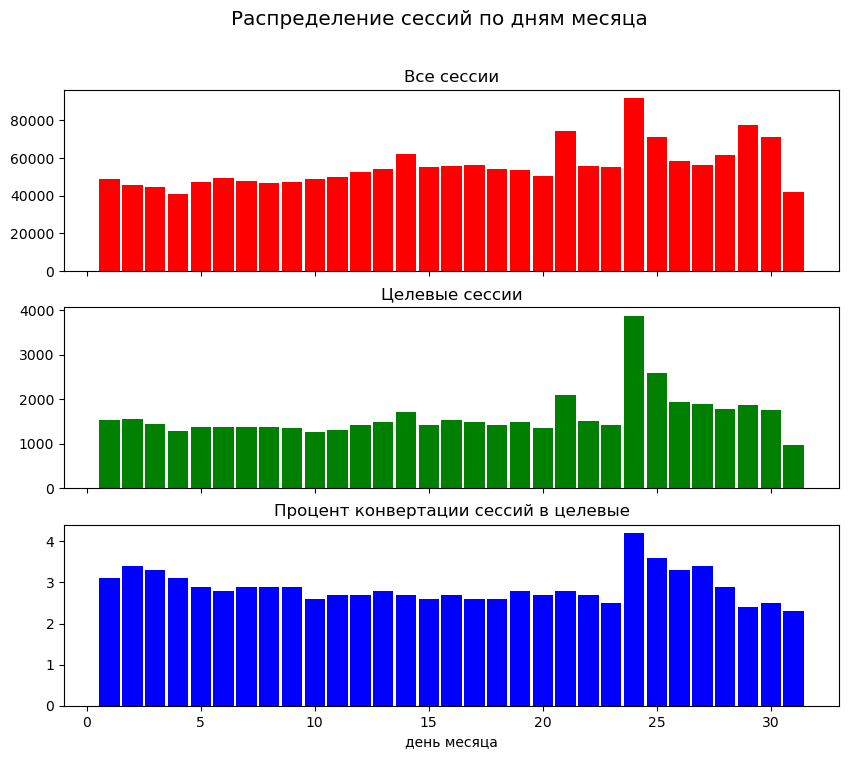

In [151]:
# Наблюдаются некоторые всплески активности, но связать это с каким-то фактором сложно.
# Возможно, некоторые числа месяца "накладывались" на более активные первые дни недели.
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, figsize=(10, 8), sharex=True)

ax1.bar(stats3['day_of_month'], stats3['target_all'], width=0.9, color='red')
ax1.set_title('Все сессии')

ax2.bar(stats3['day_of_month'], stats3['target=1'], width=0.9, color='green')
ax2.set_title('Целевые сессии')

ax3.bar(stats3['day_of_month'], stats3['target%'], width=0.9, color='blue')
ax3.set_xlabel('день месяца')
ax3.set_title('Процент конвертации сессий в целевые')

fig.suptitle('Распределение сессий по дням месяца', fontsize='x-large');

##### Зависимость от часа суток

In [152]:
# Датафрейм с количеством визитов, сгруппированных по часам дня.
stats4 = df.groupby(['hour_of_day'], as_index=False)[['target']].count()
stats4 = stats4.rename(columns={'target':'target_all'})
stats4

,hour_of_day,target_all
0,0,61864
1,1,37469
2,2,25516
3,3,19814
4,4,18986
5,5,23718
6,6,34041
7,7,50994
8,8,66758
9,9,85190


In [153]:
# Создание колонок с количеством целевых визитов по часам дня и процента консерсии.
stats4['target=1'] = stats4.hour_of_day.apply(lambda x: len(df[(df['hour_of_day'] == x) & (df['target'] == 1)]))
stats4['target%'] = round(((stats4['target=1'] / stats4['target_all'])*100), 1)
stats4

,hour_of_day,target_all,target=1,target%
0,0,61864,1883,3.0
1,1,37469,1118,3.0
2,2,25516,643,2.5
3,3,19814,483,2.4
4,4,18986,465,2.4
5,5,23718,565,2.4
6,6,34041,720,2.1
7,7,50994,1191,2.3
8,8,66758,1696,2.5
9,9,85190,2315,2.7


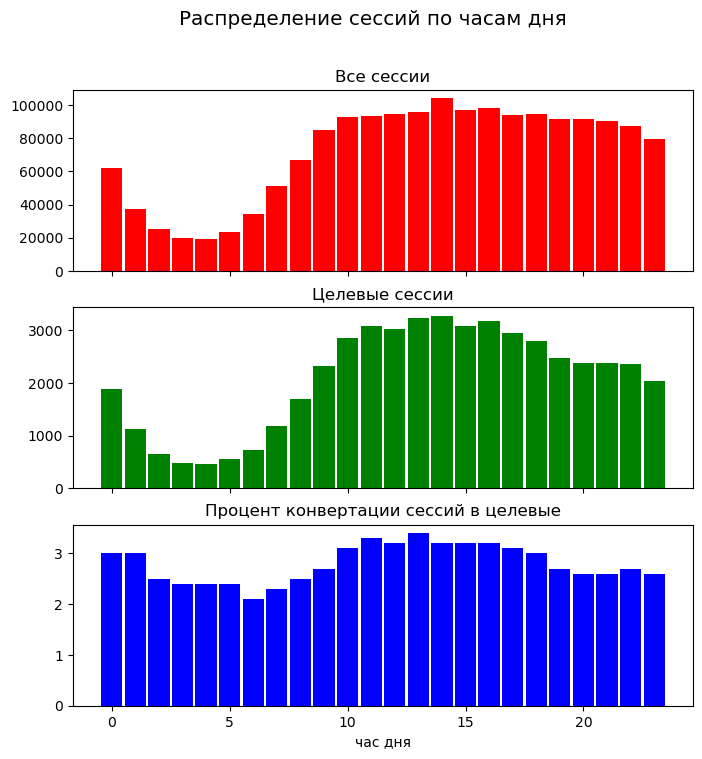

In [154]:
# Логично, что посещений сайта и целевых действий меньше в ночное время и больше в рабочее дневное время.
# Процент конверсий также меньше в ночное время, так как целевое действие (например, телефонный звонок) не всегда возможно.
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, ncols=1, figsize=(8, 8), sharex=True)

ax1.bar(stats4['hour_of_day'], stats4['target_all'], width=0.9, color='red')
ax1.set_title('Все сессии')

ax2.bar(stats4['hour_of_day'], stats4['target=1'], width=0.9, color='green')
ax2.set_title('Целевые сессии')

ax3.bar(stats4['hour_of_day'], stats4['target%'], width=0.9, color='blue')
ax3.set_xlabel('час дня')
ax3.set_title('Процент конвертации сессий в целевые')

fig.suptitle('Распределение сессий по часам дня', fontsize='x-large');

##### Зависимость от категории устройства

In [155]:
# Датафрейм с количеством визитов, сгруппированных типу устройства.
stats5 = df.groupby(['device_category'], as_index=False)[['target']].count()
stats5 = stats5.rename(columns={'target':'target_all'})
stats5

,device_category,target_all
0,desktop,346015
1,mobile,1365574
2,tablet,16637


In [156]:
# Создание колонок с количеством целевых визитов по типу устройства и процента консерсии.
stats5['target=1'] = stats5.device_category.apply(lambda x: len(df[(df['device_category'] == x) & (df['target'] == 1)]))
stats5['target%'] = round(((stats5['target=1'] / stats5['target_all'])*100), 1)
stats5

,device_category,target_all,target=1,target%
0,desktop,346015,11488,3.3
1,mobile,1365574,38300,2.8
2,tablet,16637,420,2.5


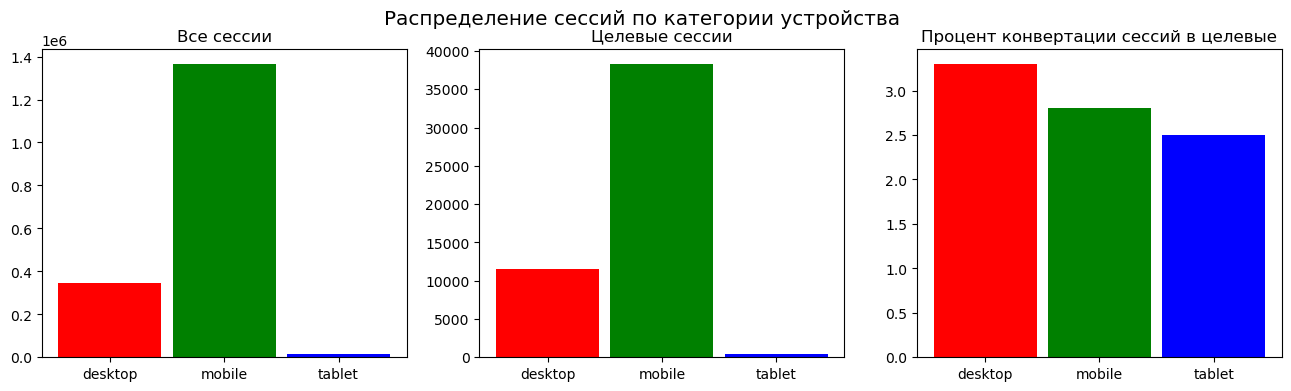

In [157]:
# Подавляющее большинство сессий генерируются мобильными устройствами, но конверсия выше со станционарных пк.
# Это можно объяснить тем, что большинство сессий происходит с рабочих мест, и с пк работать удобнее и эргномичнее.
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(16, 4), sharex=True)

ax1.bar(stats5['device_category'], stats5['target_all'], width=0.9, color=['red', 'green', 'blue'])
ax1.set_title('Все сессии')

ax2.bar(stats5['device_category'], stats5['target=1'], width=0.9, color=['red', 'green', 'blue'])
ax2.set_title('Целевые сессии')

ax3.bar(stats5['device_category'], stats5['target%'], width=0.9, color=['red', 'green', 'blue'])
ax3.set_title('Процент конвертации сессий в целевые')

fig.suptitle('Распределение сессий по категории устройства', fontsize='x-large');

##### Зависимость от возраста устройства

In [158]:
# Датафрейм с количеством визитов, сгруппированных по возрасту устройства.
stats6 = df.groupby(['device_age'], as_index=False)[['target']].count()
stats6 = stats6.rename(columns={'target':'target_all'})
stats6

,device_age,target_all
0,average,835514
1,new,178477
2,new_top,164524
3,old,549711


In [159]:
# Создание колонок с количеством целевых визитов по типу возрасту устройства и процента консерсии.
stats6['target=1'] = stats6.device_age.apply(lambda x: len(df[(df['device_age'] == x) & (df['target'] == 1)]))
stats6['target%'] = round(((stats6['target=1'] / stats6['target_all'])*100), 1)
stats6

,device_age,target_all,target=1,target%
0,average,835514,24602,2.9
1,new,178477,6258,3.5
2,new_top,164524,5049,3.1
3,old,549711,14299,2.6


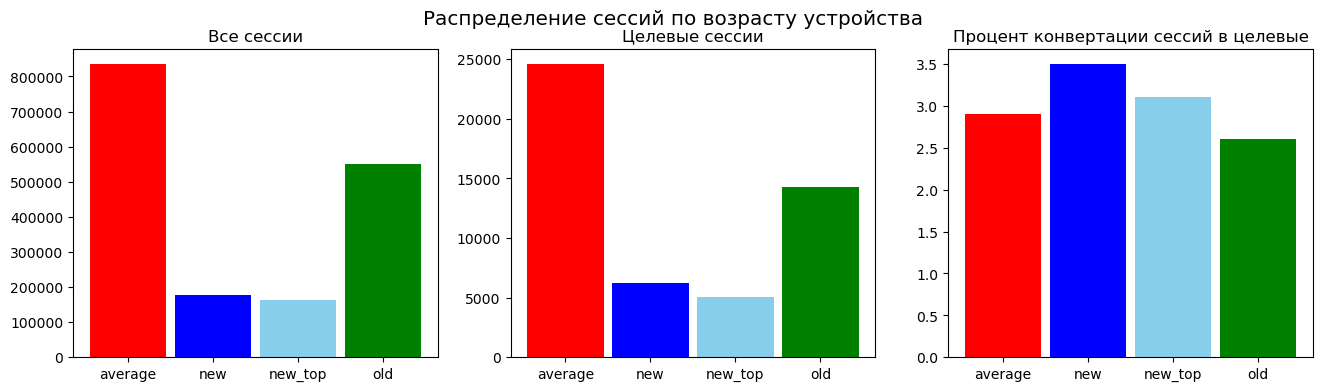

In [160]:
# Новые устройства значительно устпупают по количеству как всех, так и целевых сессий, но конверсия с них выше.
# Это объясняется преимуществом новых устройств: бастродействие; размер, разрешение и качество экрана.
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(16, 4), sharex=True)

ax1.bar(stats6['device_age'], stats6['target_all'], width=0.9, color=['red', 'blue', 'skyblue', 'green'])
ax1.set_title('Все сессии')

ax2.bar(stats6['device_age'], stats6['target=1'], width=0.9, color=['red', 'blue', 'skyblue', 'green'])
ax2.set_title('Целевые сессии')

ax3.bar(stats6['device_age'], stats6['target%'], width=0.9, color=['red', 'blue', 'skyblue', 'green'])
ax3.set_title('Процент конвертации сессий в целевые')

fig.suptitle('Распределение сессий по возрасту устройства', fontsize='x-large');

##### Зависимость от страны и региона

In [161]:
# Список стран и процента конверсий для них.
# Различие процента конверсии можно объяснить удаленностью, экономической развитостью, наличием русскоязычного населения.
# А также случаюностью, если количество вхождений страны в выборку невелико.
lst = df.geo_country.unique().tolist()
for x in lst:
    print(x, round((len(df[(df['geo_country'] == x) & (df['target'] == 1)]) / len(df[df['geo_country'] == x]) * 100), 2))

Russia 2.92
United States 0.79
Ukraine 2.38
Italy 3.8
Belarus 1.72
Sweden 1.5
Australia 3.64
Kazakhstan 2.56
Estonia 5.84
Azerbaijan 4.58
Brazil 0.91
Montenegro 2.44
Bulgaria 4.74
Georgia 3.29
Uzbekistan 2.6
Tajikistan 2.72
Ireland 0.05
Cyprus 3.68
United Arab Emirates 3.18
Germany 3.74
United Kingdom 3.28
Canada 2.67
Netherlands 2.62
Spain 3.65
Finland 2.64
Turkey 2.69
Poland 3.06
Kyrgyzstan 4.1
India 0.47
Bangladesh 0.0
Latvia 4.52
Seychelles 2.38
Norway 0.88
Armenia 3.82
Argentina 5.56
Guatemala 0.0
Lithuania 2.87
Iraq 5.75
Greece 2.08
Antigua & Barbuda 0.0
France 4.04
Slovakia 3.57
Palestine 0.0
Saudi Arabia 4.24
Iran 1.33
Czechia 2.93
Austria 3.78
Singapore 0.0
Moldova 2.17
Indonesia 1.48
Dominican Republic 2.88
Denmark 3.39
Albania 13.33
Switzerland 1.46
China 2.7
Portugal 0.0
Israel 2.51
Slovenia 11.11
Iceland 4.0
Maldives 1.81
Mexico 0.0
Wallis & Futuna 0.0
Egypt 1.79
Guadeloupe 0.0
Costa Rica 0.0
South Korea 2.42
Hungary 3.25
Uganda 0.0
Bosnia & Herzegovina 0.0
Thailand 1.27
R

In [162]:
# Процент конверсии для европейских стран (помним, что средний равен 2.91).
round((len(df[(df['is_europe'] == 1) & (df['target'] == 1)]) / len(df[df['is_europe'] == 1]) * 100), 2)

2.62

In [163]:
# Процент конверсии для постсоветских стран.
round((len(df[(df['is_post_soviet'] == 1) & (df['target'] == 1)]) / len(df[df['is_post_soviet'] == 1]) * 100), 2)

2.61

In [164]:
# Процент конверсии для ближневосточных стран.
round((len(df[(df['is_near_east'] == 1) & (df['target'] == 1)]) / len(df[df['is_near_east'] == 1]) * 100), 2)

2.86

In [165]:
# Процент конверсии для страны "Россия".
round((len(df[(df['geo_country'] == 'Russia') & (df['target'] == 1)]) / len(df[df['geo_country'] == 'Russia']) * 100), 2)

2.92

##### Зависимость от географических координат

In [166]:
# Создание объекта класса 'GeoDataFrame' библиотеки 'geopandas'.
geometry = [Point(xy) for xy in zip(df['city_long'], df['city_lat'])]
gdf = GeoDataFrame(df, geometry = geometry)

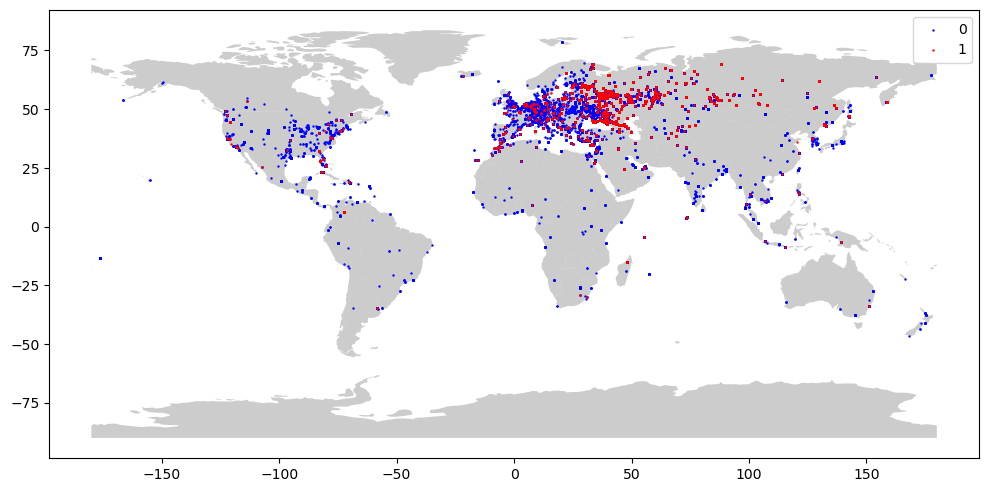

In [167]:
# Создание графика с целевыми и нецелевыми сессиями в соответствии с гео координатами на фоне географической карты.

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

fig, ax = plt.subplots(figsize=(12,12))
world.plot(ax=ax, alpha=0.4, color='grey')
gdf[gdf['target'] == 0].plot(ax=ax, markersize=0.5, color='blue', label='0')
gdf[gdf['target'] == 1].plot(ax=ax, markersize=0.5, color='red', label='1')
plt.legend(prop={'size':10})
plt.show();

In [168]:
# Удаление вспомогательного столбца, созданного для предыдущей визуализации.
# Вывод списка колонок.
df = df.drop(columns=['geometry'])
df.columns

Index(['visit_number', 'device_category', 'device_os', 'geo_country', 'target',
       'utm_source_upd', 'utm_medium_upd', 'utm_campaign_upd',
       'utm_adcontent_upd', 'device_brand_upd', 'device_browser_upd', 'month',
       'day_of_month', 'day_of_week', 'hour_of_day', 'screen_width',
       'screen_height', 'device_age', 'social_net_adv', 'organic_traffic',
       'is_post_soviet', 'is_europe', 'is_near_east', 'city_lat', 'city_long'],
      dtype='object')

##### Обновление 'geo_country'

In [169]:
# Подсчет количества значений.
df.geo_country.value_counts()

Russia               1679872
United States           8141
Ukraine                 8053
Belarus                 3432
Kazakhstan              2109
                      ...   
Costa Rica                 1
Barbados                   1
Puerto Rico                1
Rwanda                     1
Equatorial Guinea          1
Name: geo_country, Length: 158, dtype: int64

In [170]:
# Создание списка категорий с количеством значений менее 50.
lst = df.geo_country.value_counts().loc[lambda x : x < 50].index.tolist()
lst

['Syria',
 'Slovenia',
 'Tunisia',
 'Portugal',
 'Luxembourg',
 'Argentina',
 'Afghanistan',
 'Albania',
 'South Africa',
 'Slovakia',
 'Algeria',
 'Hong Kong',
 'Pakistan',
 'Iceland',
 'Nigeria',
 'Sri Lanka',
 'Taiwan',
 'Wallis & Futuna',
 'Venezuela',
 'Malaysia',
 'New Zealand',
 'Philippines',
 'Mongolia',
 'Colombia',
 'Panama',
 'Libya',
 'Malta',
 'Peru',
 'Jordan',
 'Antigua & Barbuda',
 'Qatar',
 'Myanmar (Burma)',
 'Mauritius',
 'Cambodia',
 'Oman',
 'Palestine',
 'Bahrain',
 'Kenya',
 'South Sudan',
 'Angola',
 'Senegal',
 'Uganda',
 'Andorra',
 'Guatemala',
 'Lebanon',
 'Kuwait',
 'Svalbard & Jan Mayen',
 'Bosnia & Herzegovina',
 'Nepal',
 'Ecuador',
 'North Macedonia',
 'Tanzania',
 'Chile',
 'Namibia',
 'Mozambique',
 'Monaco',
 'Ethiopia',
 'Sudan',
 'Congo - Kinshasa',
 'Togo',
 'Somalia',
 'Guinea',
 'Uruguay',
 'Nicaragua',
 'Ghana',
 'Faroe Islands',
 'Guadeloupe',
 'French Guiana',
 'Aruba',
 'Madagascar',
 'Central African Republic',
 'North Korea',
 'Haiti',
 '

In [171]:
# Обновление колонки 'geo_country' с присвоением категориям из списка lst значения 'rare'.
df['geo_country'] = df.apply(lambda x: 'rare' if x.geo_country in lst else x.geo_country, axis=1)

In [172]:
# Количество уникальных значений новой колонки.
df.geo_country.nunique()

66

In [173]:
# Размерность финального датасета.
df.shape

(1728226, 25)

In [174]:
# Checkpoint
df.to_csv('data/after_visualisation.csv', index=False)

# Стандартизация и преобразование категориальных признаков

In [175]:
# Типы данных колонок.
df.dtypes

visit_number            int64
device_category        object
device_os              object
geo_country            object
target                  int64
utm_source_upd         object
utm_medium_upd         object
utm_campaign_upd       object
utm_adcontent_upd      object
device_brand_upd       object
device_browser_upd     object
month                   int64
day_of_month            int64
day_of_week             int64
hour_of_day             int32
screen_width            int32
screen_height           int32
device_age             object
social_net_adv          int64
organic_traffic         int64
is_post_soviet          int64
is_europe               int64
is_near_east            int64
city_lat              float64
city_long             float64
dtype: object

In [176]:
df.columns

Index(['visit_number', 'device_category', 'device_os', 'geo_country', 'target',
       'utm_source_upd', 'utm_medium_upd', 'utm_campaign_upd',
       'utm_adcontent_upd', 'device_brand_upd', 'device_browser_upd', 'month',
       'day_of_month', 'day_of_week', 'hour_of_day', 'screen_width',
       'screen_height', 'device_age', 'social_net_adv', 'organic_traffic',
       'is_post_soviet', 'is_europe', 'is_near_east', 'city_lat', 'city_long'],
      dtype='object')

### Стандартизация

In [177]:
df = pd.read_csv('data/after_visualisation.csv', low_memory=False)
df.head()

,visit_number,device_category,device_os,geo_country,target,utm_source_upd,utm_medium_upd,utm_campaign_upd,utm_adcontent_upd,device_brand_upd,...,screen_width,screen_height,device_age,social_net_adv,organic_traffic,is_post_soviet,is_europe,is_near_east,city_lat,city_long
0,1,mobile,Android,Russia,0,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,Huawei,...,360,720,old,0,0,0,0,0,55.167421,59.679263
1,1,desktop,Windows,Russia,0,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,unknown,...,1366,768,new,0,1,0,0,0,55.167421,59.679263
2,1,mobile,Android,Russia,0,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,Huawei,...,360,760,old,0,0,0,0,0,55.167421,59.679263
3,2,mobile,Android,Russia,0,YlsczTIyBSwTLNtuDkCd,outlook,PTQlxxEuqjyfVHcNKQQW,JNHcPlZPxEMWDnRiyoBf,Samsung,...,385,854,average,0,0,0,0,0,55.167421,59.679263
4,1,mobile,Android,Russia,0,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,JNHcPlZPxEMWDnRiyoBf,Samsung,...,412,892,average,0,0,0,0,0,55.167421,59.679263


In [181]:
# Создание вспомогательного датафрейма, содержащего колонки с числовыми значениями.
data_numeric = df[['visit_number', 'month', 'day_of_month', 'day_of_week', 'hour_of_day', 'screen_width', 'screen_height',
                   'social_net_adv', 'organic_traffic', 'is_post_soviet', 'is_europe', 'is_near_east', 'city_lat', 'city_long']]

In [182]:
# Создание объекта класса 'StandardScaler'
std_scaler = StandardScaler()

In [183]:
# Идентификация преобразования числовых признаков.
std_scaler.fit(data_numeric)

StandardScaler()

In [184]:
# Применим преобразование.
std_scaled = std_scaler.transform(data_numeric)

In [185]:
# Создание наименований новых признаков по шаблону.
col = ['visit_number', 'month', 'day_of_month', 'day_of_week', 'hour_of_day', 'screen_width', 'screen_height',
       'social_net_adv', 'organic_traffic', 'is_post_soviet', 'is_europe', 'is_near_east', 'city_lat', 'city_long']
col_new = []

for i in col:
    col_new.append(i + '_std') 
    
col_new

['visit_number_std',
 'month_std',
 'day_of_month_std',
 'day_of_week_std',
 'hour_of_day_std',
 'screen_width_std',
 'screen_height_std',
 'social_net_adv_std',
 'organic_traffic_std',
 'is_post_soviet_std',
 'is_europe_std',
 'is_near_east_std',
 'city_lat_std',
 'city_long_std']

In [186]:
# Добавим в исходный датафрейм получившиеся новые признаки.
df[col_new] = std_scaled
df.head()

,visit_number,device_category,device_os,geo_country,target,utm_source_upd,utm_medium_upd,utm_campaign_upd,utm_adcontent_upd,device_brand_upd,...,hour_of_day_std,screen_width_std,screen_height_std,social_net_adv_std,organic_traffic_std,is_post_soviet_std,is_europe_std,is_near_east_std,city_lat_std,city_long_std
0,1,mobile,Android,Russia,0,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,Huawei,...,0.063193,-0.538581,-0.692647,-0.416971,-0.609063,-0.106502,-0.089708,-0.048081,0.470641,0.761485
1,1,desktop,Windows,Russia,0,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,unknown,...,-0.099919,1.275572,-0.412819,-0.416971,1.641867,-0.106502,-0.089708,-0.048081,0.470641,0.761485
2,1,mobile,Android,Russia,0,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,Huawei,...,-0.915477,-0.538581,-0.459457,-0.416971,-0.609063,-0.106502,-0.089708,-0.048081,0.470641,0.761485
3,2,mobile,Android,Russia,0,YlsczTIyBSwTLNtuDkCd,outlook,PTQlxxEuqjyfVHcNKQQW,JNHcPlZPxEMWDnRiyoBf,Samsung,...,0.878751,-0.493498,0.088541,-0.416971,-0.609063,-0.106502,-0.089708,-0.048081,0.470641,0.761485
4,1,mobile,Android,Russia,0,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,JNHcPlZPxEMWDnRiyoBf,Samsung,...,1.368086,-0.444808,0.310072,-0.416971,-0.609063,-0.106502,-0.089708,-0.048081,0.470641,0.761485


### Преобразование категориальных признаков

In [187]:
# Количество уникальных значений категориальных колонок.
df[['device_category', 'device_os', 'geo_country', 'utm_source_upd', 'utm_medium_upd', 'utm_campaign_upd', 'utm_adcontent_upd',
    'device_brand_upd', 'device_browser_upd', 'device_age']].nunique()

device_category         3
device_os              12
geo_country            66
utm_source_upd         57
utm_medium_upd         25
utm_campaign_upd      118
utm_adcontent_upd      72
device_brand_upd       51
device_browser_upd     14
device_age              4
dtype: int64

In [188]:
# Создание вспомогательного датафрейма с категориальными колонками.
data_object = df[['device_category', 'device_os', 'geo_country', 'utm_source_upd', 'utm_medium_upd', 'utm_campaign_upd', 
                  'utm_adcontent_upd', 'device_brand_upd', 'device_browser_upd', 'device_age']]

In [189]:
# Создание объекта класса 'OneHotEncoder'
ohe = OneHotEncoder(sparse=False)

In [190]:
# Идентифицируем и применим преобразование категориальных признаков.
ohe_data = pd.DataFrame(ohe.fit_transform(data_object), columns=ohe.get_feature_names())
ohe_data.shape

(1728226, 422)

In [191]:
# Добавим в исходный датафрейм получившиеся новые признаки.
df = df.join(ohe_data)
df.head()

,visit_number,device_category,device_os,geo_country,target,utm_source_upd,utm_medium_upd,utm_campaign_upd,utm_adcontent_upd,device_brand_upd,...,x8_Safari (in-app),x8_Samsung Internet,x8_UC Browser,x8_YaBrowser,x8_[FBAN,x8_rare,x9_average,x9_new,x9_new_top,x9_old
0,1,mobile,Android,Russia,0,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,Huawei,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1,desktop,Windows,Russia,0,fDLlAcSmythWSCVMvqvL,(none),LTuZkdKfxRGVceoWkVyg,JNHcPlZPxEMWDnRiyoBf,unknown,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,1,mobile,Android,Russia,0,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,Huawei,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,2,mobile,Android,Russia,0,YlsczTIyBSwTLNtuDkCd,outlook,PTQlxxEuqjyfVHcNKQQW,JNHcPlZPxEMWDnRiyoBf,Samsung,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,1,mobile,Android,Russia,0,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,JNHcPlZPxEMWDnRiyoBf,Samsung,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [192]:
# Удалим колонки, которые были исходными для формирования признаков.
columns_for_drop = ['visit_number', 'month', 'day_of_month', 'day_of_week', 'hour_of_day', 'screen_width', 'screen_height',
                    'social_net_adv', 'organic_traffic', 'is_post_soviet', 'is_europe', 'is_near_east', 'city_lat', 'city_long',
                    'device_category', 'device_os', 'geo_country', 'utm_source_upd', 'utm_medium_upd', 'utm_campaign_upd', 
                    'utm_adcontent_upd', 'device_brand_upd', 'device_browser_upd', 'device_age']

df = df.drop(columns=columns_for_drop)

In [193]:
df.head()

,target,visit_number_std,month_std,day_of_month_std,day_of_week_std,hour_of_day_std,screen_width_std,screen_height_std,social_net_adv_std,organic_traffic_std,...,x8_Safari (in-app),x8_Samsung Internet,x8_UC Browser,x8_YaBrowser,x8_[FBAN,x8_rare,x9_average,x9_new,x9_new_top,x9_old
0,0,-0.139838,0.778572,0.785187,-0.399353,0.063193,-0.538581,-0.692647,-0.416971,-0.609063,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0,-0.139838,1.231297,-0.011013,0.607179,-0.099919,1.275572,-0.412819,-0.416971,1.641867,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0,-0.139838,0.778572,1.240158,1.613711,-0.915477,-0.538581,-0.459457,-0.416971,-0.609063,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0,-0.054030,0.778572,1.467644,-0.902619,0.878751,-0.493498,0.088541,-0.416971,-0.609063,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0,-0.139838,0.778572,-0.465985,1.110445,1.368086,-0.444808,0.310072,-0.416971,-0.609063,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [194]:
df.shape

(1728226, 437)

In [195]:
# Checkpoint
df.to_csv('data/after_scaler_and_ohe.csv', index=False)

# Modelling

In [2]:
%%time
df = pd.read_csv('data/after_scaler_and_ohe.csv', low_memory=False)
df.head()

Wall time: 2min 31s


,target,visit_number_std,month_std,day_of_month_std,day_of_week_std,hour_of_day_std,screen_width_std,screen_height_std,social_net_adv_std,organic_traffic_std,...,x8_Safari (in-app),x8_Samsung Internet,x8_UC Browser,x8_YaBrowser,x8_[FBAN,x8_rare,x9_average,x9_new,x9_new_top,x9_old
0,0,-0.139838,0.778572,0.785187,-0.399353,0.063193,-0.538581,-0.692647,-0.416971,-0.609063,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0,-0.139838,1.231297,-0.011013,0.607179,-0.099919,1.275572,-0.412819,-0.416971,1.641867,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0,-0.139838,0.778572,1.240158,1.613711,-0.915477,-0.538581,-0.459457,-0.416971,-0.609063,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0,-0.054030,0.778572,1.467644,-0.902619,0.878751,-0.493498,0.088541,-0.416971,-0.609063,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0,-0.139838,0.778572,-0.465985,1.110445,1.368086,-0.444808,0.310072,-0.416971,-0.609063,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [3]:
%%time
# Инициализируем фичи и целевую переменную. 
x = df.drop(['target'], axis=1)
y = df.target

# Делим данные на трейн и тест.
# Тесту выделили 20% (держим в уме последующий делёж трейна на 'фолды' в кросс-валидации). Выборкам лучше быть близкими по размеру.
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=73)

Wall time: 23.6 s


### RandomForestClassifier

In [4]:
# Объявляем модель Случайного леса с параметрами по умолчанию, задействовав все процессоры пк.
forest = RandomForestClassifier(n_jobs=-1)

In [5]:
%%time
# Проводим кросс-валидацию тренировочной выборки, разделив ее на четыре 'фолда'.
cv_score = cross_val_score(forest, x_train, y_train, scoring='roc_auc', cv=4, n_jobs=-1, error_score='raise')

# Средний показатель roc_auc и его дисперсия.
print(round(cv_score.mean(),4), round(cv_score.std(),4))

0.6341 0.0013
Wall time: 15min 47s


In [6]:
# Вывод параметров по умолчанию, с которыми обучилась модель, и часть из которых будем тюнинговать.
forest.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [7]:
%%time
# Тюнинг глубины дерева.
max_depth_grid = [15, 20, 25, 30, 35]
forest_tuning = []

for max_depth in max_depth_grid:
    forest = RandomForestClassifier(max_depth=max_depth, random_state=73, n_jobs=-1)
    cv_score = cross_val_score(forest, x_train, y_train, scoring='roc_auc', cv=4, n_jobs=-1, error_score='raise')
    forest_tuning.append([round(cv_score.mean(),4), round(cv_score.std(),4)])
       
param_value = list(zip(max_depth_grid, forest_tuning))
param_value.sort(key = lambda x: x[1][0], reverse=True)

param_value
# Помним, что, уменьшая глубину обучаемого дерева, предотвращаем переобучение. Также смотрим на дисперсию.
# Выбираем для дальнейшего тюнинга max_depth=25

Wall time: 55min


[(25, [0.6995, 0.0002]),
 (20, [0.6994, 0.0007]),
 (30, [0.6938, 0.0007]),
 (15, [0.6919, 0.0015]),
 (35, [0.6836, 0.0011])]

In [8]:
%%time
# Тюнинг количества деревьев в лесу.
trees_grid = [80, 120, 140, 160, 180]
forest_tuning = []

for ntrees in trees_grid:
    forest = RandomForestClassifier(n_estimators=ntrees, max_depth=25, random_state=73, n_jobs=-1)
    cv_score = cross_val_score(forest, x_train, y_train, scoring='roc_auc', cv=4, n_jobs=-1, error_score='raise')
    forest_tuning.append([round(cv_score.mean(),4), round(cv_score.std(),4)])
    
param_value = list(zip(trees_grid, forest_tuning))
param_value.sort(key = lambda x: x[1][0], reverse=True)

param_value
# Выберем n_estmators=180

Wall time: 1h 15min 42s


[(180, [0.7015, 0.0002]),
 (160, [0.7014, 0.0005]),
 (140, [0.7008, 0.0005]),
 (120, [0.7004, 0.0004]),
 (80, [0.6981, 0.0003])]

In [9]:
%%time
# Тюнинг минимального числа листьев в ветке.
min_samples_leaf_grid = [1, 2, 3, 5, 7]
forest_tuning = []

for min_samples_leaf in min_samples_leaf_grid:
    forest= RandomForestClassifier(min_samples_leaf=min_samples_leaf, n_estimators=180, max_depth=25, random_state=73,
                                   n_jobs=-1)
    cv_score = cross_val_score(forest, x_train, y_train, scoring='roc_auc', cv=4, n_jobs=-1, error_score='raise')
    forest_tuning.append([round(cv_score.mean(),4), round(cv_score.std(),4)])
    
param_value = list(zip(min_samples_leaf_grid, forest_tuning))
param_value.sort(key = lambda x: x[1][0], reverse=True)

param_value
# Выбираем min_samples_leaf=2 

Wall time: 1h 31min 23s


[(2, [0.7047, 0.0003]),
 (3, [0.7043, 0.0006]),
 (5, [0.7036, 0.0007]),
 (7, [0.7028, 0.0008]),
 (1, [0.7015, 0.0002])]

In [10]:
%%time
# Минимальное количество объектов для ращепления.
min_samples_split_grid = [2, 3, 5, 7, 9]
forest_tuning = []

for min_samples_split in min_samples_split_grid:
    forest= RandomForestClassifier(min_samples_split=min_samples_split, min_samples_leaf=2, n_estimators=180, max_depth=25, 
                                   random_state=73, n_jobs=-1)
    cv_score = cross_val_score(forest, x_train, y_train, scoring='roc_auc', cv=4, n_jobs=-1, error_score='raise')
    forest_tuning.append([round(cv_score.mean(),4), round(cv_score.std(),4)])
    
param_value = list(zip(min_samples_split_grid, forest_tuning))
param_value.sort(key = lambda x: x[1][0], reverse=True)

param_value
# Выбираем min_samples_split=5 

Wall time: 1h 33min 16s


[(2, [0.7047, 0.0003]),
 (3, [0.7047, 0.0003]),
 (5, [0.7047, 0.0006]),
 (9, [0.7047, 0.0007]),
 (7, [0.7046, 0.0007])]

In [11]:
%%time
# Тюнинг числа признаков, по которым ищется разбиение.
max_features_grid = [25, 30, 35, 40, 45]
forest_tuning= []

for max_features in max_features_grid:
    forest= RandomForestClassifier(max_features=max_features, min_samples_split=5, min_samples_leaf=2, n_estimators=180, 
                                   max_depth=25, random_state=73, n_jobs=-1)
    cv_score = cross_val_score(forest, x_train, y_train, scoring='roc_auc', cv=4, n_jobs=-1, error_score='raise')
    forest_tuning.append([round(cv_score.mean(),4), round(cv_score.std(),4)])
        
param_value = list(zip(max_features_grid, forest_tuning))
param_value.sort(key = lambda x: x[1][0], reverse=True)

param_value
# Выбираем max_features=35

Wall time: 2h 16min 13s


[(30, [0.707, 0.0004]),
 (35, [0.707, 0.0006]),
 (25, [0.7063, 0.0004]),
 (40, [0.7062, 0.0003]),
 (45, [0.7057, 0.0006])]

In [4]:
%%time
# Обучим модель с лучшими параметрами на тренировочной выборке.
# Выведем значение roc_auc на тестовой (ранее отложенной) выборке.
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=73)
forest= RandomForestClassifier(max_features=35, min_samples_split=5, min_samples_leaf=2, n_estimators=180, max_depth=25, 
                               random_state=73, n_jobs=-1)
forest.fit(x_train, y_train)
forest_pred_test = forest.predict(x_test)
forest_probs = forest.predict_proba(x_test)[:, 1]
print('Итоговая тюнингованная модель Случайного леса')
print('Значение метрики на тестовой выборке: ', round(roc_auc_score(y_test, forest_probs),4)) 

Итоговая тюнингованная модель Случайного леса
Значение метрики на тестовой выборке:  0.7111
Wall time: 9min 44s


In [13]:
# Матрица ошибок
confusion_matrix(y_test, forest_pred_test)

array([[335663,      8],
       [  9945,     30]], dtype=int64)

### LogisticRegression

In [4]:
# Объявляем модель логистической регрессии с параметрами по умолчанию, задействовав все процессоры пк.
logreg = LogisticRegression(n_jobs=-1)

In [5]:
%%time
# Проводим кросс-валидацию тренировочной выборки, разделив ее на четыре 'фолда'.
cv_score = cross_val_score(logreg, x_train, y_train, scoring='roc_auc', cv=4, n_jobs=-1, error_score='raise')

# Средний показатель roc_auc и его дисперсия.
print(round(cv_score.mean(),4), round(cv_score.std(),4))

0.6819 0.0012
Wall time: 9min 52s


In [6]:
# Вывод параметров, с которыми обучилась модель, и часть из которых будем тюнинговать.
logreg.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': -1,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

Путем перебора допустимых комбинаций значений параметров solver (значения: lbfgs, liblinear, newton-cg, newton-cholesky, sag,
saga) и penalty (значения: l2, l1, none) установлено, что изменние метрики происходит незначительное.

In [7]:
%%time
# Остановим выбор на solver='sag' и penalty='l2'. При этих параметрах обучение происходит быстрее.
logreg = LogisticRegression(penalty='l2', solver='sag', random_state=73, n_jobs=-1)
cv_score = cross_val_score(logreg, x_train, y_train, scoring='roc_auc', cv=4, n_jobs=-1, error_score='raise')
print(round(cv_score.mean(),4), round(cv_score.std(),4))

0.6827 0.0012
Wall time: 22min 2s


In [8]:
%%time
# Тюнинг параметра 'C', отвечающего за степень регуляризации.
C_grid = [0.1, 0.01, 0.001]
logreg_tuning = []

for C in C_grid:
    logreg = LogisticRegression(C=C, penalty='l2', solver='sag', random_state=73, n_jobs=-1)
    cv_score = cross_val_score(logreg, x_train, y_train, scoring='roc_auc', cv=4, n_jobs=-1, error_score='raise')
    logreg_tuning.append([round(cv_score.mean(),4), round(cv_score.std(),4)])
    
param_value = list(zip(C_grid, logreg_tuning))
param_value.sort(key = lambda x: x[1][0], reverse=True)

param_value

Wall time: 46min 24s


[(0.1, [0.682, 0.001]), (0.01, [0.6759, 0.0004]), (0.001, [0.6632, 0.0015])]

In [9]:
%%time
# Обучим модель с лучшими параметрами на тренировочной выборке.
# Выведем значение roc_auc на тестовой (ранее отложенной) выборке.
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=73)
logreg = LogisticRegression(C=0.1, penalty='l2', solver='sag', random_state=73, n_jobs=-1)
logreg.fit(x_train, y_train)
logreg_pred_test = logreg.predict(x_test)
logreg_probs = logreg.predict_proba(x_test)[:, 1]
print('Итоговая тюнингованная модель Логистической регрессии')
print('Значение метрики на тестовой выборке: ', round(roc_auc_score(y_test, logreg_probs),4)) 

C:\Users\user\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


Итоговая тюнингованная модель Логистической регрессии
Значение метрики на тестовой выборке:  0.6844
Wall time: 8min 36s


In [11]:
# Матрица ошибок
confusion_matrix(y_test, logreg_pred_test)

array([[335670,      1],
       [  9975,      0]], dtype=int64)

### MLPClassifier

In [12]:
# Объявляем модель Многослойного персептрона с параметрами по умолчанию.
neural = MLPClassifier()

In [13]:
%%time
# Проводим кросс-валидацию тренировочной выборки, разделив ее на четыре 'фолда'.
cv_score = cross_val_score(neural, x_train, y_train, scoring='roc_auc', cv=4, n_jobs=-1, error_score='raise')

# Средний показатель roc_auc и его дисперсия.
print(round(cv_score.mean(),4), round(cv_score.std(),4))

0.6974 0.0015
Wall time: 41min 57s


In [7]:
# Вывод параметров, с которыми обучилась модель, и часть из которых будем тюнинговать.
neural.get_params()

{'activation': 'relu',
 'alpha': 0.0001,
 'batch_size': 'auto',
 'beta_1': 0.9,
 'beta_2': 0.999,
 'early_stopping': False,
 'epsilon': 1e-08,
 'hidden_layer_sizes': (100,),
 'learning_rate': 'constant',
 'learning_rate_init': 0.001,
 'max_fun': 15000,
 'max_iter': 200,
 'momentum': 0.9,
 'n_iter_no_change': 10,
 'nesterovs_momentum': True,
 'power_t': 0.5,
 'random_state': None,
 'shuffle': True,
 'solver': 'adam',
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': False,
 'warm_start': False}

In [6]:
%%time
# Тюнинг размера скрытого слоя.
hidden_layer_sizes_grid = [(100,), (150,), (200,), (250,), (300,)]
neural_tuning = []

for hidden_layer_sizes in hidden_layer_sizes_grid:
    neural = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes, random_state=73)
    cv_score = cross_val_score(neural, x_train, y_train, scoring='roc_auc', cv=4, n_jobs=-1, error_score='raise')
    neural_tuning.append([round(cv_score.mean(),4), round(cv_score.std(),4)])
        
param_value = list(zip(hidden_layer_sizes_grid, neural_tuning))
param_value.sort(key = lambda x: x[1][0], reverse=True)

param_value

Wall time: 6h 55min 39s


[((100,), [0.6974, 0.0012]),
 ((150,), [0.6963, 0.001]),
 ((200,), [0.6946, 0.0014]),
 ((300,), [0.6942, 0.0005]),
 ((250,), [0.6928, 0.0014])]

In [8]:
%%time
# Попробуем добавить дополнительный скрытый слой.
hidden_layer_sizes_grid = [(100,50), (150,75), (200,100), (250,125)]
neural_tuning = []

for hidden_layer_sizes in hidden_layer_sizes_grid:
    neural = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes, max_iter=200, random_state=73)
    cv_score = cross_val_score(neural, x_train, y_train, scoring='roc_auc', cv=4, n_jobs=-1, error_score='raise')
    neural_tuning.append([round(cv_score.mean(),4), round(cv_score.std(),4)])
        
param_value = list(zip(hidden_layer_sizes_grid, neural_tuning))
param_value.sort(key = lambda x: x[1][0], reverse=True)

param_value
# При ввведении дополнительного слая метрики понижаются, поэтому оставим один внутрении слой размером 100.

Wall time: 6h 51min 37s


[((100, 50), [0.6879, 0.0018]),
 ((150, 75), [0.6869, 0.0066]),
 ((250, 125), [0.6852, 0.0027]),
 ((200, 100), [0.6786, 0.0028])]

In [5]:
%%time
# Тюнинг функции активации скрытого слоя.
activation_grid = ['identity', 'logistic', 'tanh', 'relu']
neural_tuning = []

for activation in activation_grid:
    neural = MLPClassifier(activation=activation, hidden_layer_sizes=(100,50), random_state=73)
    cv_score = cross_val_score(neural, x_train, y_train, scoring='roc_auc', cv=4, n_jobs=-1, error_score='raise')
    neural_tuning.append([round(cv_score.mean(),4), round(cv_score.std(),4)])
    
param_value = list(zip(activation_grid, neural_tuning))
param_value.sort(key = lambda x: x[1][0], reverse=True)

param_value

Wall time: 5h 5min 32s


[('logistic', [0.6995, 0.0008]),
 ('relu', [0.6879, 0.0018]),
 ('identity', [0.6811, 0.0012]),
 ('tanh', [0.6612, 0.0026])]

In [8]:
%%time
# Тюнинг коэффициента регуляризации с функцией активации 'logistic'.
alpha_grid = [0.001, 0.01, 0.1, 1]
neural_tuning = []

for alpha in alpha_grid:
    neural = MLPClassifier(alpha=alpha, activation='logistic', hidden_layer_sizes=(100,50), random_state=73)
    cv_score = cross_val_score(neural, x_train, y_train, scoring='roc_auc', cv=4, n_jobs=-1, error_score='raise')
    neural_tuning.append([round(cv_score.mean(),4), round(cv_score.std(),4)])
        
param_value = list(zip(alpha_grid, neural_tuning))      
param_value.sort(key = lambda x: x[1][0], reverse=True)

param_value

Wall time: 2h 5min 51s


[(0.001, [0.6956, 0.0004]),
 (0.01, [0.6826, 0.0011]),
 (0.1, [0.6332, 0.003]),
 (1, [0.5091, 0.0267])]

In [9]:
%%time
# Тюнинг коэффициента регуляризации с функцией активации 'tanh'.
alpha_grid = [0.001, 0.01, 0.1, 1]
neural_tuning = []

for alpha in alpha_grid:
    neural = MLPClassifier(alpha=alpha, activation='tanh', hidden_layer_sizes=(100,50), random_state=73)
    cv_score = cross_val_score(neural, x_train, y_train, scoring='roc_auc', cv=4, n_jobs=-1, error_score='raise')
    neural_tuning.append([round(cv_score.mean(),4), round(cv_score.std(),4)])
        
param_value = list(zip(alpha_grid, neural_tuning))
param_value.sort(key = lambda x: x[1][0], reverse=True)

param_value

Wall time: 2h 10min 19s


[(0.001, [0.7002, 0.0012]),
 (0.01, [0.6921, 0.0009]),
 (0.1, [0.675, 0.0007]),
 (1, [0.6203, 0.0038])]

In [10]:
%%time
# Обучим модель с лучшими параметрами на тренировочной выборке.
# Выведем значение roc_auc на тестовой (ранее отложенной) выборке.
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=73)
neural = MLPClassifier(alpha=0.001, activation='tanh', hidden_layer_sizes=(100,50), random_state=73)
neural.fit(x_train, y_train)
neural_pred_test = neural.predict(x_test)
neural_probs = neural.predict_proba(x_test)[:, 1]
print('Итоговая тюнингованная модель Нейронной сети')
print('Значение метрики на тестовой выборке: ', round(roc_auc_score(y_test, neural_probs),4)) 

Итоговая тюнингованная модель Нейронной сети
Значение метрики на тестовой выборке:  0.6988
Wall time: 18min 37s


In [11]:
# Матрица ошибок
confusion_matrix(y_test, neural_pred_test)

array([[335665,      6],
       [  9955,     20]], dtype=int64)

### Results

In [5]:
# Имеем следующую сводную таблицу
data = pd.DataFrame({'RandomForestClassifier':[0.6341,0.707,0.0006,0.7111],'LogisticRegression':[0.6819,0.0682,0.001,0.684],
                     'MLPClassifier':[0.6974,0.7002,0.0012,0.6988]},
                    index=['среднее значение roc_auc на кросс-валидации при параметрах по умолчанию на train-выборке',
                           'среднее значение roc_auc на кросс-валидации после тюнинга параметров на train-выборке',
                           'дисперсия roc_auc на кросс-валидации после тюнинга параметров на train-выборке',
                           'roc_auc после тюнинга на отложенной test-выборке'])
data

,RandomForestClassifier,LogisticRegression,MLPClassifier
среднее значение roc_auc на кросс-валидации при параметрах по умолчанию на train-выборке,0.6341,0.6819,0.6974
среднее значение roc_auc на кросс-валидации после тюнинга параметров на train-выборке,0.7070,0.0682,0.7002
дисперсия roc_auc на кросс-валидации после тюнинга параметров на train-выборке,0.0006,0.0010,0.0012
roc_auc после тюнинга на отложенной test-выборке,0.7111,0.6840,0.6988


ПОБЕДИТЕЛЬ - Случайный лес.

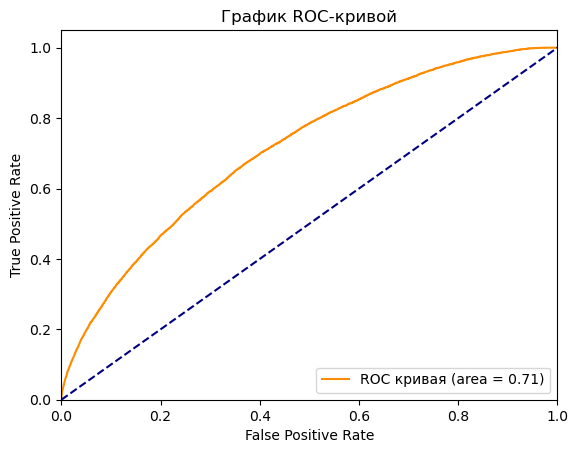

In [6]:
# Построение графика roc-кривой.
fpr, tpr, treshold = roc_curve(y_test, forest_probs)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange',
         label='ROC кривая (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('График ROC-кривой')
plt.legend(loc="lower right")
plt.show()

В зависимости от задач и рисков бизнесса при выборе порога принятия решений модели можно руководствоваться следующим графиком.

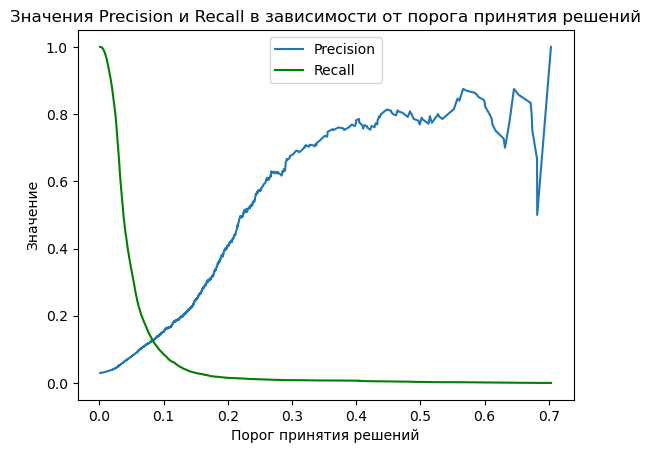

In [7]:
# Построения графика для анализа зависимости точности, отзыва и порога принятия решений.
precision, recall, threshold = precision_recall_curve(y_test, forest_probs)

plt.plot(threshold, precision[:-1], label='Precision')
plt.plot(threshold, recall[:-1], 'g-', label='Recall')
plt.ylabel('Значение')
plt.xlabel('Порог принятия решений')
plt.title('Значения Precision и Recall в зависимости от порога принятия решений')
plt.legend(loc='best')
plt.show()

In [3]:
%%time
# Обучаем лучшую модель на всём датасете.
x = df.drop(['target'], axis=1)
y = df.target

forest= RandomForestClassifier(max_features=35, min_samples_split=5, min_samples_leaf=2, n_estimators=180, max_depth=25, 
                               random_state=73, n_jobs=-1)
forest.fit(x, y)

Wall time: 10min 50s


RandomForestClassifier(max_depth=25, max_features=35, min_samples_leaf=2,
                       min_samples_split=5, n_estimators=180, n_jobs=-1,
                       random_state=73)

In [6]:
%%time
# Сохраняем обученную модель в pickle-файл.
filename = 'final_model.pickle'

with open(filename, 'wb') as file:
  pickle.dump(forest, file)

Wall time: 541 ms
